# Series de Tiempo 
## Guía Completa con Ejemplos

#### Por Carlos Santillán

#### Febrero 2020

## 1. ¿Qué es una Serie de Tiempo?

Una serie de tiempo es una secuencia de observaciones en tiempos regulares.

Puen existir series de tiempo por hora, día, semana, mes, trimestre y anual. En algunas ocasiones también se pueden tener datos por minuto e incluso segundos.

**¿Por qué analizar una Serie de Tiempo?**

- Es el paso previo a poder realizar un forecast

**¿Qué implica analizar una Serie de Tiempo?**

- El análisis implica entender los aspectos de la naturaleza inherente de los datos; de esta manera se puede estar mejor informado y dar un forecast mucho más certero.

## 2. Lecturad de Datos en Python

Los datos, por buena practica de Data Science, deben ser guardados en formato *csv*, pero Python puede abrir documentos de Excel por igual.

A continuación se importaran las librerías necesarias para realizar un análisis por series de tiempo. En particular, la librería **Pandas** posee las funciones *read_csv* y *read_excel* que nos ayudan a importar los datos. 

La función *parse_dates=['date']* hará que la columna con fechas tenga formato de fecha

In [76]:
from dateutil.parser import parse     ### Fechas
import matplotlib as mpl              ### Gráficas
import matplotlib.pyplot as plt       ### Gráficas
import seaborn as sns                 ### Gráficas
import numpy as np                    ### Vectores
import pandas as pd                   ### DataFrames

### Dimensiones de gráficas
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.tsa.stattools import adfuller, kpss

from scipy import signal

from pandas.plotting import autocorrelation_plot

from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pandas.plotting import lag_plot

from statsmodels.nonparametric.smoothers_lowess import lowess

from statsmodels.tsa.stattools import grangercausalitytests

from pmdarima.arima.utils import ndiffs

from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm


Importamos como DataFrame:

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                 parse_dates=['date'])
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


De igual modo, podemos importar como serie de Pandas con las fechas como índice. Sólo es necesario especificar el argumento de *index_col* en la función *pd.read_csv()*

In [4]:
ser = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                  parse_dates=['date'],
                  index_col='date')
ser.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


Nótese que la columna "value" aparece más arriba que la de "date", esto nos indica que está en formato de serie

## 3. ¿Qué son los datos panel?

También son datos basados en tiempo. La diferencia es que adicionalmente a la serie de tiempo a analizar, encontraremos otras variables relacionadas que han sido medidas en los mismos periodos de tiempo.

Por lo general, las columnas en datos panel contienen variables explicatorias que pueden ser útiles en predecir $Y$, asumiento que dichas columnas también existirán en el futuro (en el periodo sobre el que se hará el forecast).

A continuación un ejemplo:

In [6]:
### source: https://github.com/rouseguy
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/MarketArrivals.csv')
df = df.loc[df.market=='MUMBAI', :]    ### Filtramos para datos de MUMBAI
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
6654,MUMBAI,January,2004,267100,719,971,849,MS,MUMBAI,January-2004
6655,MUMBAI,January,2005,275845,261,513,387,MS,MUMBAI,January-2005
6656,MUMBAI,January,2006,228000,315,488,402,MS,MUMBAI,January-2006
6657,MUMBAI,January,2007,205200,866,1136,997,MS,MUMBAI,January-2007
6658,MUMBAI,January,2008,267550,348,550,448,MS,MUMBAI,January-2008


## 4. Visualizando una Serie de Tiempo

Esta vez, usaremos la librería *matplotlib* para visualizar nuestros datos:

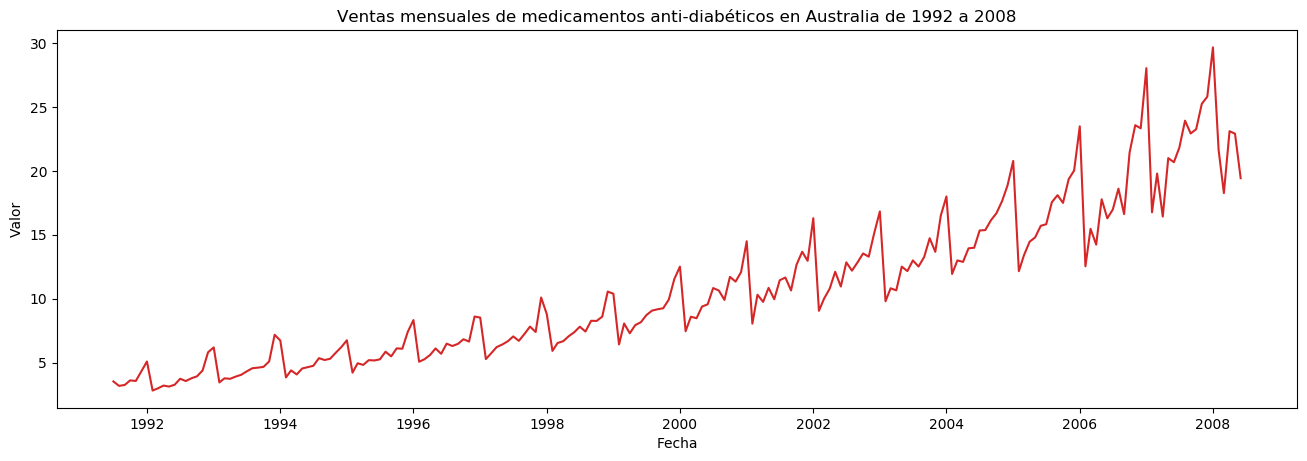

In [9]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                 parse_dates=['date'],
                 index_col='date')

### Dibujamos gráfico
def plot_df(df, x, y, title="", xlabel='Fecha', ylabel='Valor', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title,
                  xlabel=xlabel,
                  ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.value, title='Ventas mensuales de medicamentos anti-diabéticos en Australia de 1992 a 2008')    

Como los datos son mensuales y tienen cierto comportamiento repetitivo (patrón) año con año, podemos graficar cada año como una trayectoria separada en la misma gráfica.

Esto nos permitirá comparar las patrones anuales uno contra otro:

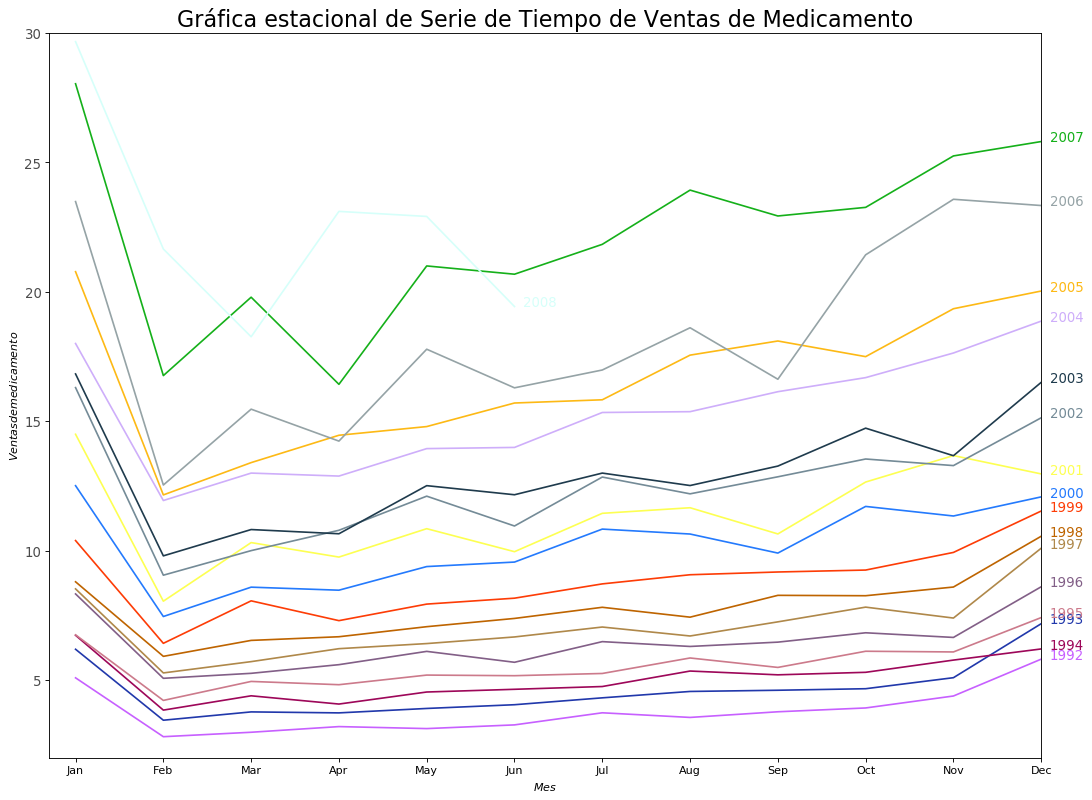

In [11]:
### Importamos datos
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                 parse_dates=['date'],
                 index_col='date')
df.reset_index(inplace=True)

### Preparamos los datos
df['year'] = [d.year for d in df.date]             ### porción de año
df['month'] = [d.strftime('%b') for d in df.date]  ### porción de mes
years = df['year'].unique()                        ### valores únicos para años

### Preparamos colores
np.random.seed(100)     ### inicializamos semilla de simulación
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()),     ### lista de colores
                            len(years),                              ### tantos colores como años
                            replace=False)                           ### muestreo sin reemplazo

### Dibujamos gráfica
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'value', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

### Decoración
plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$Ventas de medicamento$', xlabel='$Mes$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Gráfica estacional de Serie de Tiempo de Ventas de Medicamento", fontsize=20)
plt.show()

Observamos una clara caida de las ventas en Febrero, se alzan de nuevo en Marzo, caen una segunda vez en Abril y así sucesivamente.

Claramente, el patrón se repite año con año, para todos los años.

Nótese también que a lo largo de los años las ventas incrementan en su totalidad. Podemos visualizar esta tendencia y como varía año con año en una **gráfica de caja y brazos** anual. De igual manera, podemos hacerla mensual.

**Gráfico de Caja y Brazos de distribución mensual (estacional) y anual (tendencia)**

Podemos agrupar los datos en intervalos estacionales y observar cómo es que estos valores se distribuyen a lo largo de un mes o año dados, comparándolos así en el tiempo:

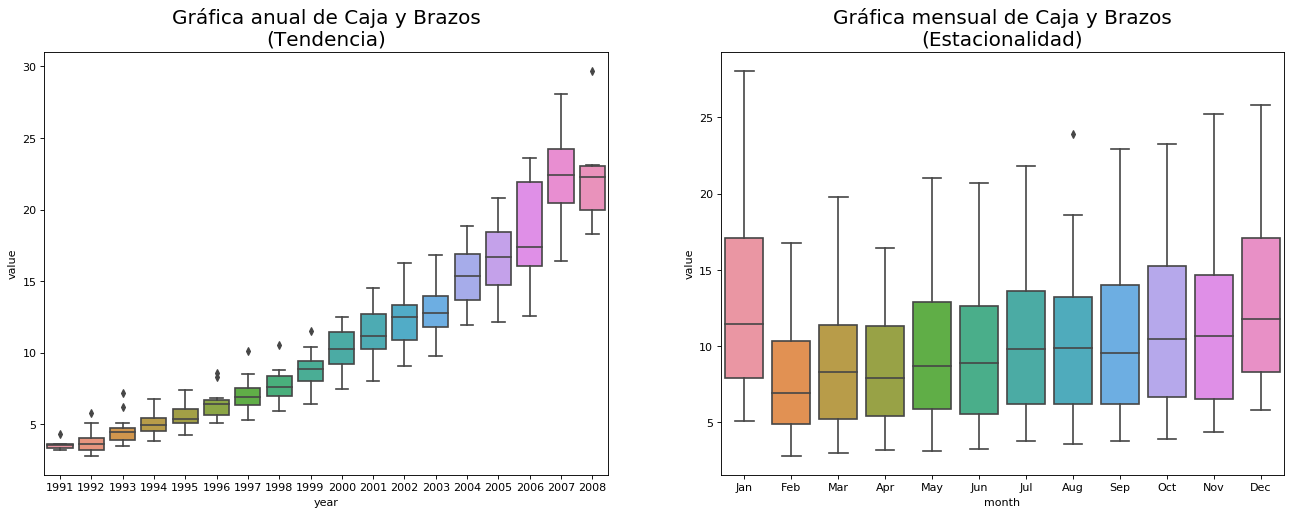

In [12]:
### Importamos datos
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                 parse_dates=['date'],
                 index_col='date')
df.reset_index(inplace=True)

### Preparamos datos
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

### Dibujamos gráficos
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='value', data=df, ax=axes[0])
sns.boxplot(x='month', y='value', data=df.loc[~df.year.isin([1991, 2008]), :])

### Ponemos títulos
axes[0].set_title('Gráfica anual de Caja y Brazos\n(Tendencia)', fontsize=18); 
axes[1].set_title('Gráfica mensual de Caja y Brazos\n(Estacionalidad)', fontsize=18)
plt.show()

Las gráficas de Caja y Brazos hacen evidente las distribuciones mensuales y anuales. Nótese que en la gráfica mensual, los meses de Diciembre y Enero tienen mayores ventas, lo cual podríamos atribuir a descuentos por la temporada de regalos.

Hasta ahora hemos visto las cualidades de encontrar los patrones en los datos, pero, ¿Podemos encontrar las desviaciones inusuales del patrón observado?

## 5. Patrones en la Serie de Tiempo

Una **Serie de Tiempo Aditiva** puede ser definida como:

$$S_{t} = b_{t} + T_{t} + E_{t} + W_{t}$$

Donde:

- $b_{t}$: **Nivel base**, entiéndase como los datos sin el efecto de las otras componentes


- $T_{t}$: **Componente de Tendencia**, se observa cuand hay un comportamiento creciente o decreciente muy marcado


- $E_{t}$: **Componente de Estacionalidad / Temporalidad**, es cuando hay un patrón repetido observado entre intervalos regulares originado por factores relativos a esa temporada. Es muy importante **no confundir con una serie ESTACIONARIA**, en inglés es más fácil distinguir estos dos conceptos, pues $E_{t}$ es *seasonality* y la propiedad de una serie de ser estacionaria es *stationarity*


- $W_{t}$: **Componente de Ruido**, todo aquello que no es inherente al comportamiento de los datos, señales que no son consistentes con lo observado. Este puede ser *ruido blanco* (Gaussiano) o de otro tipo.

Recordemos que este es un modelo de series de tiempo y no implica que sea obligatorio que todas las series presenten estos componentes. Una serie de tiempo podría no tener una componente de tendencia pero sí tener estacionalidad. Lo opuesto también es posible.

De modo que podemos entender una serie de tiempo como la combinación de tendencia, estacionalidad y ruido:

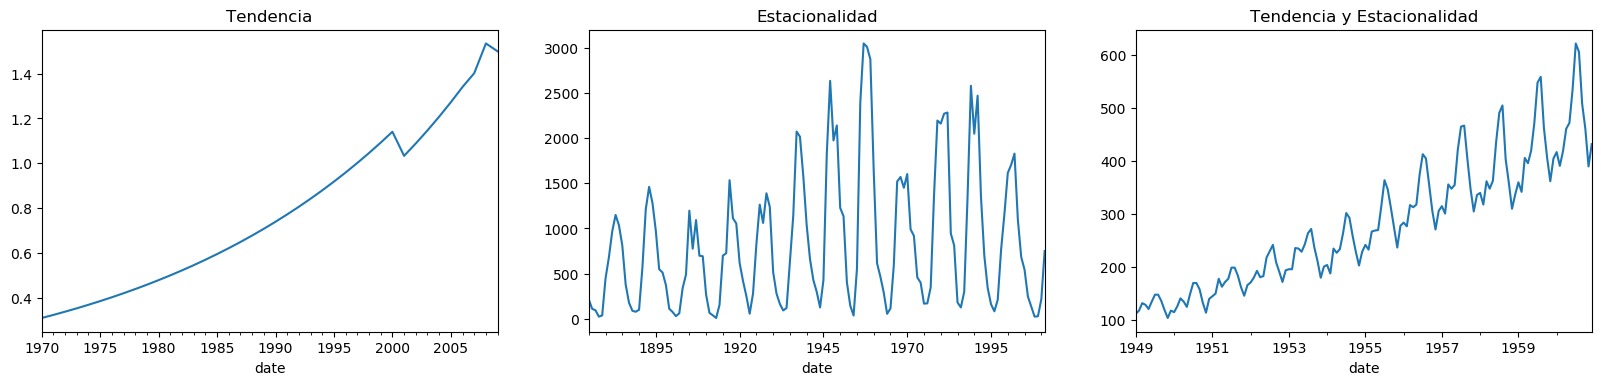

In [13]:
fig, axes = plt.subplots(1,3, figsize=(20,4), dpi=100)
pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/guinearice.csv', parse_dates=['date'], index_col='date').plot(title='Tendencia', legend=False, ax=axes[0])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv', parse_dates=['date'], index_col='date').plot(title='Estacionalidad', legend=False, ax=axes[1])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv', parse_dates=['date'], index_col='date').plot(title='Tendencia y Estacionalidad', legend=False, ax=axes[2])

Otro aspecto importante a considerar en las series de tiempo es el **Comportamiento Cíclico**. Este sucede cuando el patrón de caidas y subidas no sucede en intervalos calendario fijos. Es importante no confundir el efecto cíclico con el efecto estacional.

Entonces, ¿Cómo diferenciar entre un patrón cíclico vs uno estacional?

- Si los patrones no tienen una frecuencia fija basada en el calendario, entonces son cíclicos. Esto es gracias a que, contrario al factor estacional, el factor cíclico se ve influido por el negocio y otros factores socio-económicos.

## 6. Series Multiplicativas vs Aditivas

Dependiendo de la naturaleza de la tendencia y la estacionalidad, una serie de tiempo puede ser modelada como aditiva o multiplicativa, donde cada observación en la serie puede ser expresada ya sea como una suma o como un producto:

**Serie de Tiempo Aditiva:**
- $S_{t} = b_{t} + T_{t} + E_{t} + W_{t}$

**Serie de Tiempo Multiplicativa:**
- $S_{t} = b_{t} * T_{t} * E_{t} * W_{t}$

## 7. ¿Cómo descomponer una Serie de Tiempo?

Afortunadamente, en la librería de Python *statsmodels* existe la función *seasonal_decompose* que nos permite implementar esta descomposición de manera sencilla:

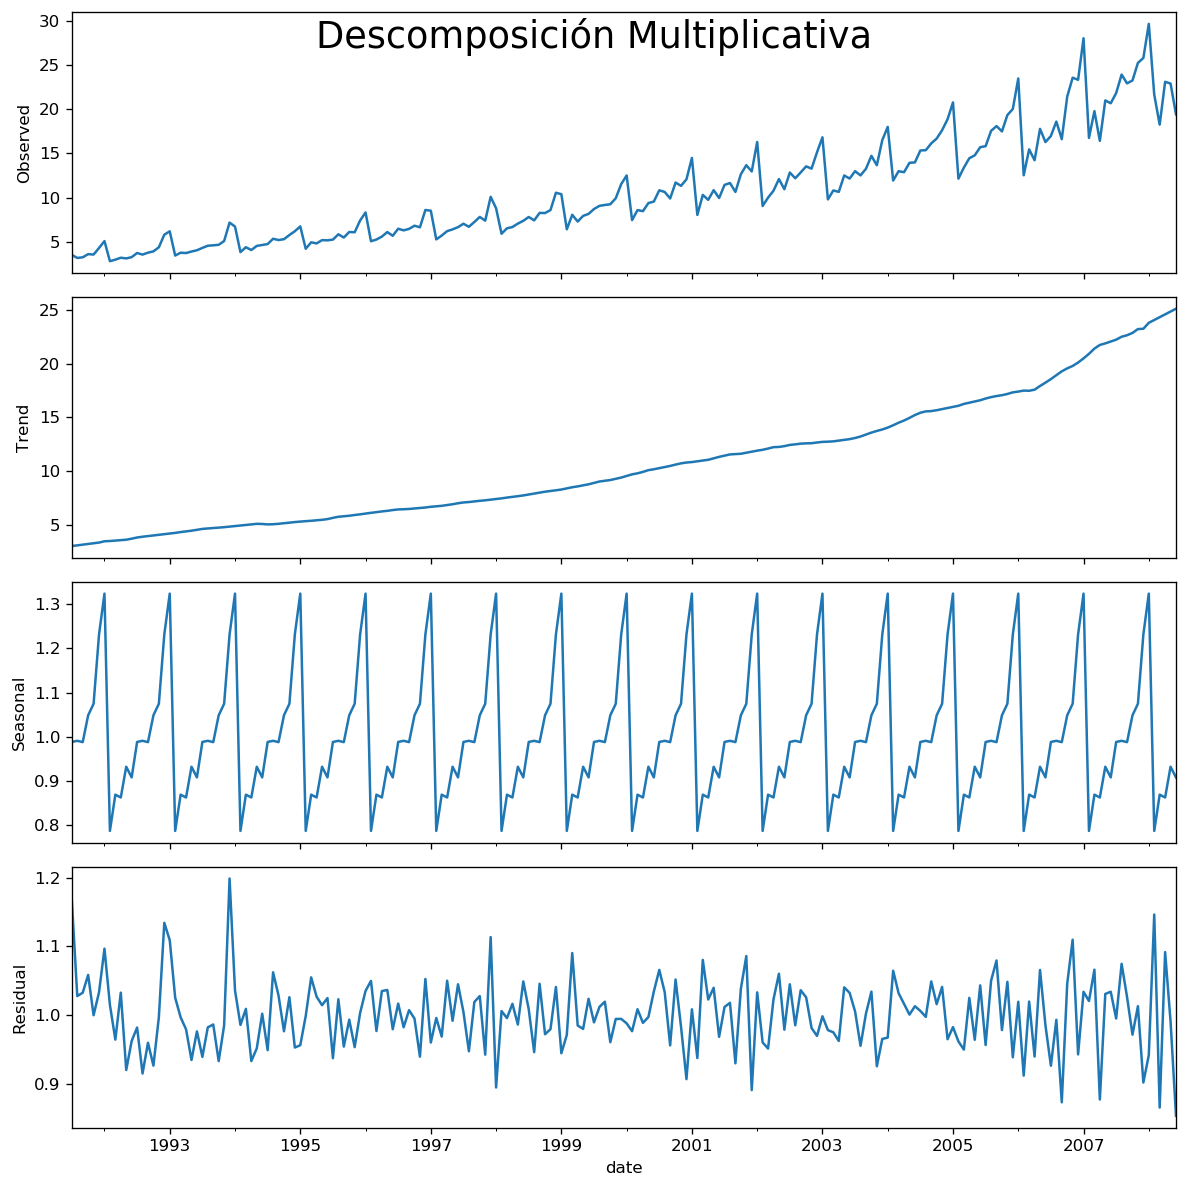

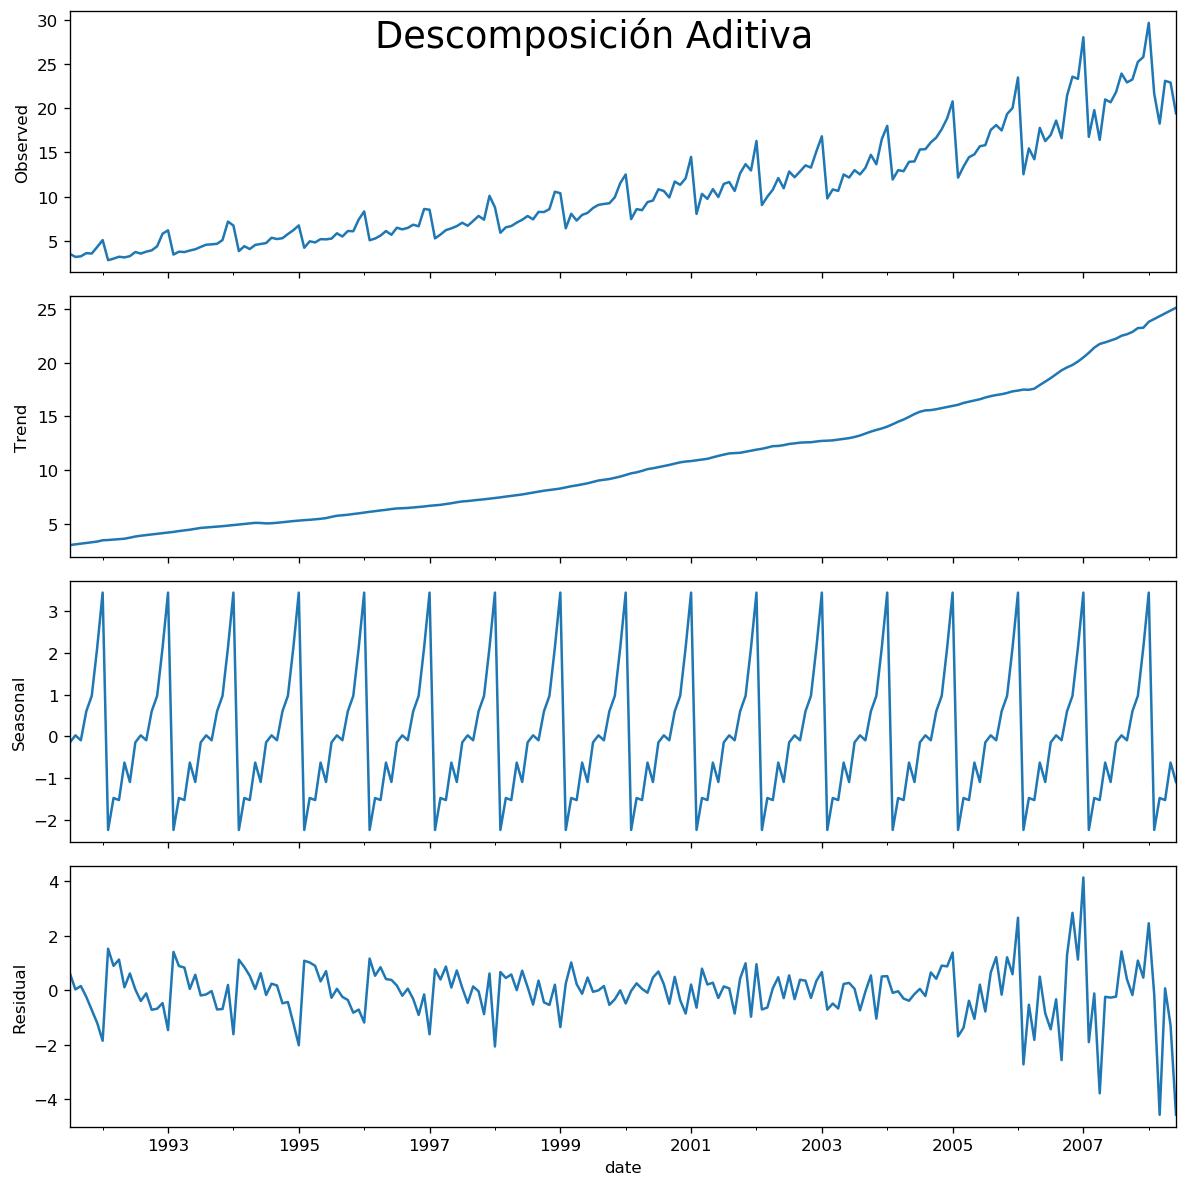

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

### Importamos los datos
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                 parse_dates=['date'],
                 index_col='date')

### Descomposición Multiplicativa 
result_mul = seasonal_decompose(df['value'],
                                model='multiplicative',
                                extrapolate_trend='freq')

### Descomposición Aditiva
result_add = seasonal_decompose(df['value'],
                                model='additive',
                                extrapolate_trend='freq')

### Gráficas
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Descomposición Multiplicativa', fontsize=22)
result_add.plot().suptitle('Descomposición Aditiva', fontsize=22)
plt.show()


Usando el argumento *extrapolate_trend = 'freq'* nos ocupamos de cualquier valor missing en la tendencia y en los residuales al inicio de la serie.

Si observamos los residuales de la descomposición aditiva podemos notar que aun tienen un patrón restante. No así en la descomposición multiplicativa, en la cual los residuales se observan aleatorios, lo cual es bueno. Para esta serie, la descomposición multiplicativa es preferida.

El output numérico de las componentes se guarda en *result_mult*, podemos extraerlo y ponerlo en un DataFrame:

In [16]:
### Extracción de componentes
### Valores actuales = Producto de (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal,
                              result_mul.trend,
                              result_mul.resid,
                              result_mul.observed],
                             axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
date,,,,
1991-07-01,0.987845,3.060085,1.166629,3.526591
1991-08-01,0.990481,3.124765,1.027745,3.180891
1991-09-01,0.987476,3.189445,1.032615,3.252221
1991-10-01,1.048329,3.254125,1.058513,3.611003
1991-11-01,1.074527,3.318805,0.999923,3.565869


Se puede corroborar que el producto de *seas, trend* y *resid* es exactamente igual al valore de *actual_values*


In [17]:
df_reconstructed['Comprobacion'] = df_reconstructed['seas'] * df_reconstructed['trend'] * df_reconstructed['resid']
df_reconstructed.head()

,seas,trend,resid,actual_values,Comprobacion
date,,,,,
1991-07-01,0.987845,3.060085,1.166629,3.526591,3.526591
1991-08-01,0.990481,3.124765,1.027745,3.180891,3.180891
1991-09-01,0.987476,3.189445,1.032615,3.252221,3.252221
1991-10-01,1.048329,3.254125,1.058513,3.611003,3.611003
1991-11-01,1.074527,3.318805,0.999923,3.565869,3.565869


## 8. Series de Tiempo Estacionarias vs No Estacionarias

La *estacionariedad* es una propiedad muy importante de las Series de Tiempo. En una **serie estacionaria** los valores de la serie **no son función del tiempo ($t$)**

Esto quiere decir que las propiedades estadísticas de la serie de datos, como lo son la media, varianza y autocorrelación son constantes a lo largo del tiempo. La *autocorrelación* no es más que la correlación de la serie con sus valores previos, después hablaré más sobre el tema.

**Importante:** una serie estacionaria es **carente de efecto estacional**

Entonces, ¿Cómo identificar si una serie es estacionaria o no? A través de las siguientes gráficas podemos clarificar un poco el concepto:

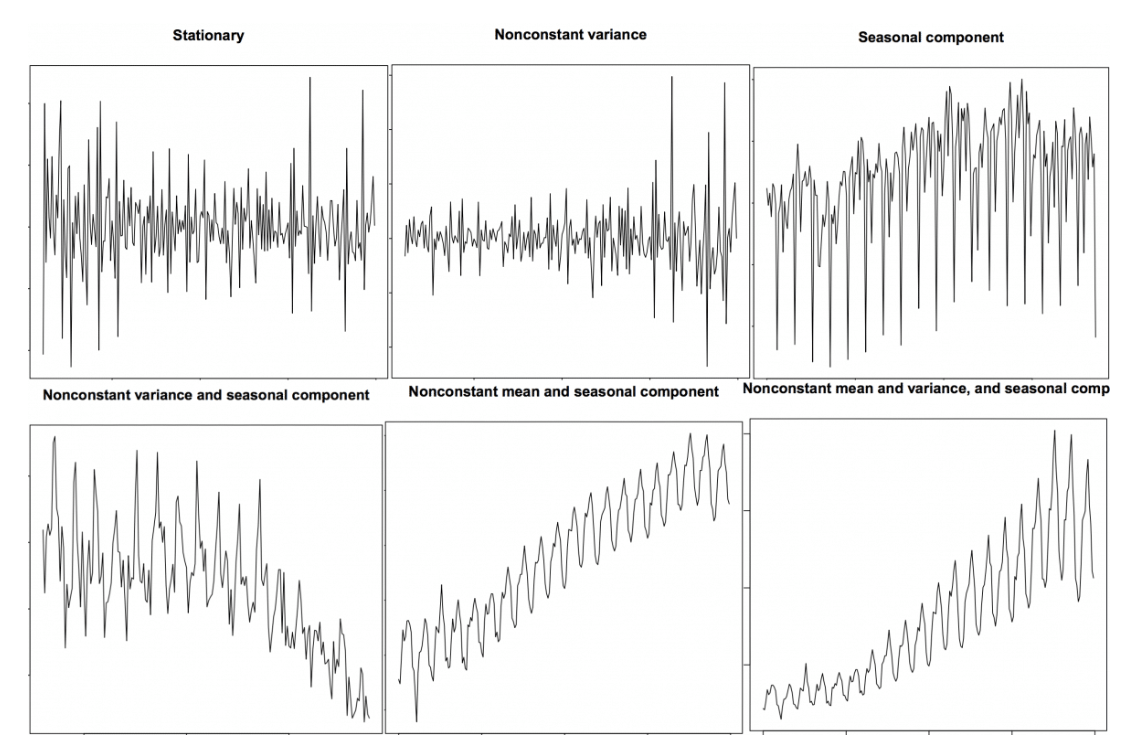

La imagen anterior tiene como fuente el tutorial para R sobre Series de Tiempo

¿Por qué nos importa la estacionariedad de una serie?

Más adelante hablaré más a fondo de ello, pero lo importante es entender que prácticamente cualquier serie de tiempo puede ser transformada en una serie estacionaria usando el método correcto. La mayoría de los modelos estadísticos para forecasting están diseñados para funcionar en series de tiempo estacionarias. 

El primer paso en un proceso de forecasting usualmente es transformar nuestros datos para convertir una serie no-estacionaria a una estacionaria

## 9. ¿Cómo hacer que una Serie de Tiempo sea Estacionaria?

Se puede conseguir una Serie de Tiempo Estacionaria de las siguientes maneras:

1. Diferenciando la serie (una o más veces)

2. Tomando el logaritmo de la serie

3. Tomando la raíz n-ésima de la serie

4. Combinación de las anteriores

La manera más común (y conveniente) de *estacionarizar* una serie es mediante la diferenciación de la serie hasta que esta sea *aproximadamente estacionaria*

A todo esto, ¿Qué es diferenciar una serie?

Si $T_{t}$ es el valor de la serie en el tiempo $t$, entonces la primer¨diferencia de $Y$ es:

$$Y = Y_{t} - Y_{t-1}$$

En términos más simples, diferenciar una serie no es más que restar al valor siguiente el valor anterior (i.e. obtener la diferencia entre el tiempo $t$ y $t-1$)

Si la primer diferencia no vuelve a la serie estacionaria, podemos hacer una segunda diferencia y así sucesivamente.

Por ejemplo, consideremos la serie:

$$[1, 5, 2, 12, 20]$$

La primer diferencia nos da:

$$[5-1, 2-5, 12-2, 20-12] = [4, -3, 10, 8]$$

La segunda diferencia nos da:

$$[-3-4, 10-3, 8-10] = [-7, 7, -2]$$

## 9. ¿Por qué es necesario hacer que una serie no-estacionaria sea estacionaria antes de hacer forecasting?

En términos generales, hacer forecasting sobre una serie estacionaria es más fácil y los pronósticos son más confiables.

Matemáticamente hablando, una razón importante es que los modelos de *forecasting autoregresivos* son escencialmente *modelos de regresión lineal* que utilizan los *lag(s)* de la serie como predictores.

Sabemos que la regresión lineal funciona mejor cuando los predictores (las variables X) no están correlacionadas entre ellas. Entonces, al estacionarizar una serie resolvemos el problema puesto que este proceso quita cualquier autocorrelación persistente, haciendo entonces que los predictores (lags de las series) sean prácticamente independientes.

Ya que hemos entendido porqué es importante que una serie sea estacionaria, es necesario preguntarnos cómo podemos saber si una serie dada es estacionaria o no.

## 10. Pruebas de Estacionariedad

Una manera de saber si la serie con la que estamos trabajando es estacionaria es fijándonos en su gráfica como hemos hecho antes.

Otro método es partir la serie en 2 o más partes contigÜas y calcular las medidas de tendencia centrar como la media, varianza y autocorrelación. Si las medidas son lo suficientemente diferentes, entonces es muy probable que la serie sea no-estacionaria.

De todas maneras, necesitamos un *método cuantitativo* para determinar si la serie es estacionaria o no. Esto se puede hacer usando *pruebas estadísticas* llamadas **Pruebas de Raíz Unitaria**. Hay múltiples variantes de este método, como lo son:

1. Prueba Aumentada de Dickey-Fuller (ADH Test)

2. Prueba de Kwiatkowski-Philips-Schmidt-Shin (KPSS test, tendencia estacionaria)

3. Prueba de Philips-Perron (PP Test)

La más utilizada es el ADH Test, en el cual la hipótesis nula es que la serie de tiempo poseé una raíz unitaria y es no-estacionaria. Entonces, si:

$$p-value_{ADH} < \alpha \Rightarrow rechazamos H_{0}$$

Usualmente el valore de $\alpha$ es de $0.05$ (este es el nivel de significancia)

Por otro lado, el KPSS Test es usado para determinar estacionariedad en la tendencia. En este caso la hipótesis nula y la interpretación del *p-value* son opuestos a las del ADH Test. 

El siguiente código implementa ambas pruebas usando la librería *statsmodels*:

In [20]:
from statsmodels.tsa.stattools import adfuller, kpss

### Lectura de datos
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                 parse_dates=['date'])

### ADF Test
result = adfuller(df.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Valores Críticos:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df.value.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Valores Críticos:')
    print(f'   {key}, {value}')

ADF Statistic: 3.1451856893067434
p-value: 1.0
Valores Críticos:
   1%, -3.465620397124192
Valores Críticos:
   5%, -2.8770397560752436
Valores Críticos:
   10%, -2.5750324547306476

KPSS Statistic: 1.313675
p-value: 0.010000
Valores Críticos:
   10%, 0.347
Valores Críticos:
   5%, 0.463
Valores Críticos:
   2.5%, 0.574
Valores Críticos:
   1%, 0.739


C:\Users\SANTICA4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\SANTICA4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


## 11. Diferencia entre Ruído Blanco y Serie Estacionaria

Al igual que una serie estacionaria, el ruído blanco es no-dependiente del tiempo, esto quiere decir que su media y varianza no cambian a lo largo del tiempo. La diferencia radica en que el ruido blanco es completamente aleatorio y su media es de 0

En el ruído blanco no hay patrón alguno. Si consideraramos las señales de sonido de una estación de radio FM como una serie de tiempo, el ruido que escuchamos entre los cambios de estación es ruido blanco.

Matemáticamente hablando, una secuencia de números completamente aleatorios con media 0 es un ruido blanco:

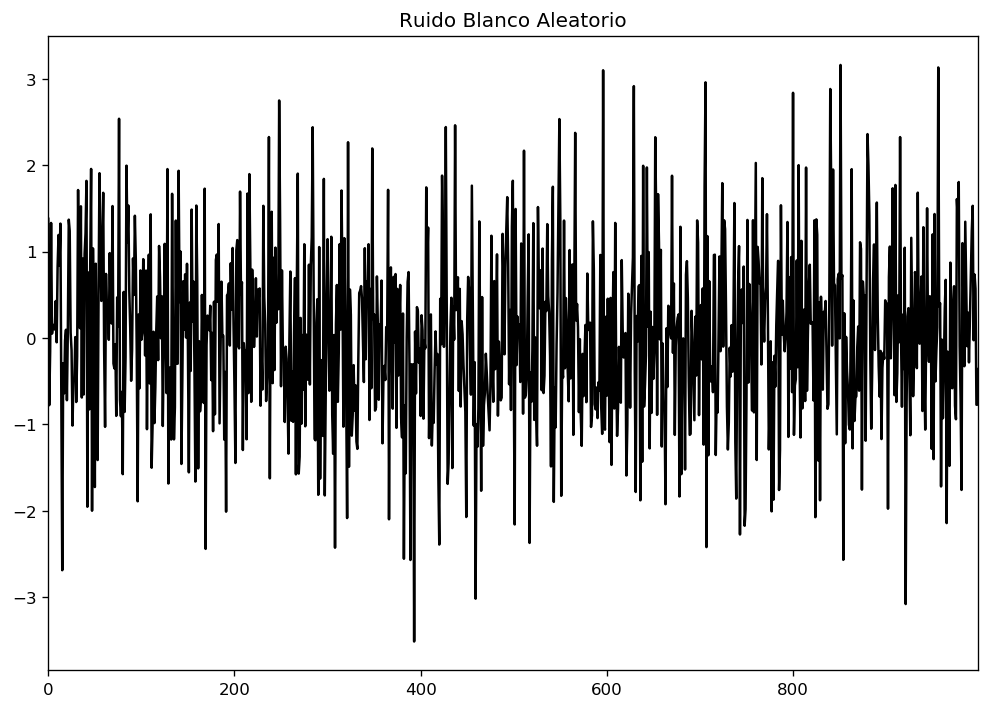

In [21]:
randvals = np.random.randn(1000)
pd.Series(randvals).plot(title='Ruido Blanco Aleatorio', color='k')

## 12. ¿Cómo eliminar la Tendencia de una Serie de Tiempo?

Existen maneras distintas de hacerlo:

1. Restar la linea de mejor ajuste a la serie. La línea de mejor ajuste puede ser obtenida mediante una regresión lineal con los índices de tiempo como el predictor. Para tendencia más complejas, podríamos usar términos cuadráticos ($X^{2}$) en el modelo.


2. Restar el componente de tendencia obtenido por la descomposición que vimos antes


3. Restar la media


4. Aplicar un filtro como el Baxter-King (*statsmodels.tsa.filters.bkfilter*) o el Hodrick-Prescott (*statsmodels.tsa.filters.hpfilter*) para remover las lineas de tendencia de las medias móviles o los componentes cíclicos.

Implementemos los primeros dos métodos:

**Restar linea de mejor ajuste**

Text(0.5, 1.0, 'Venta de medicamentes des-tendenciada por ajuste de Mínimos Cuadrados')

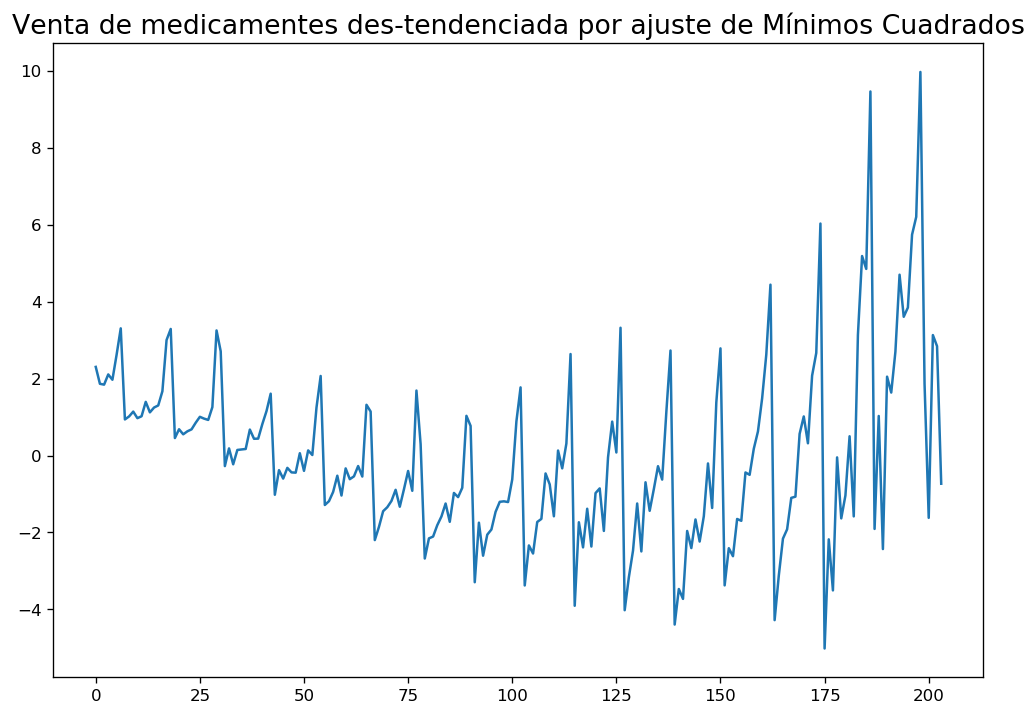

In [23]:
from scipy import signal

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                 parse_dates=['date'])
detrended = signal.detrend(df.value.values)
plt.plot(detrended)
plt.title('Venta de medicamentes des-tendenciada por ajuste de Mínimos Cuadrados', fontsize=16)

**Restar componente de tendencia**

Text(0.5, 1.0, 'Venta de medicamentos des-tendenciada por Componente de Tendencia')

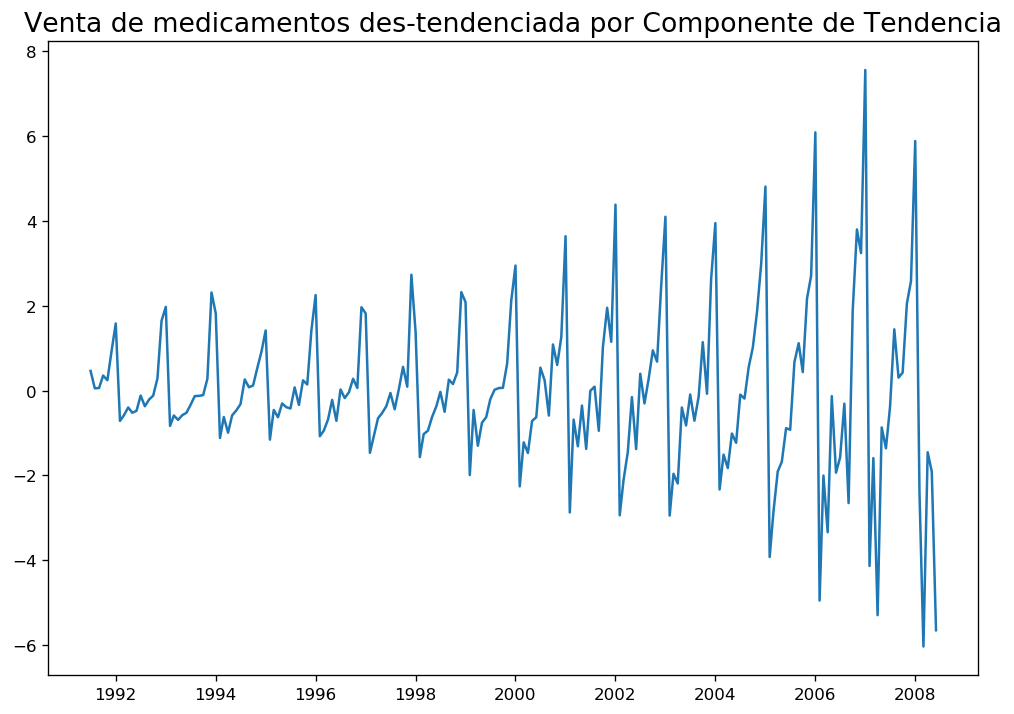

In [24]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                 parse_dates=['date'],
                 index_col='date')
result_mul = seasonal_decompose(df['value'],
                                model='multiplicative',
                                extrapolate_trend='freq')
detrended = df.value.values - result_mul.trend
plt.plot(detrended)
plt.title('Venta de medicamentos des-tendenciada por Componente de Tendencia', fontsize=16)

## 13. ¿Cómo desestacionalizar una Serie de Tiempo?

Nuevamente, existen múltiples métodos, a continuación algunos:

1. Tomar medias móviles con longitud igual al intervalo estacional. Esto también suaviza la serie en el proceso.


2. Diferenciar estacionalmente la serie (restar el valor de la estacionalidad previa al valor de la estacionalidad actual).


3. Dividir la serie entre el índice estacional obtenido por la descomposición STL

Si dividir entre el índice estacionalidad no funciona, podemos probar tomando el logaritmo de la serie y después desestacionalizar. Podemos después regresar al valor original tomando la exponencial.

[]

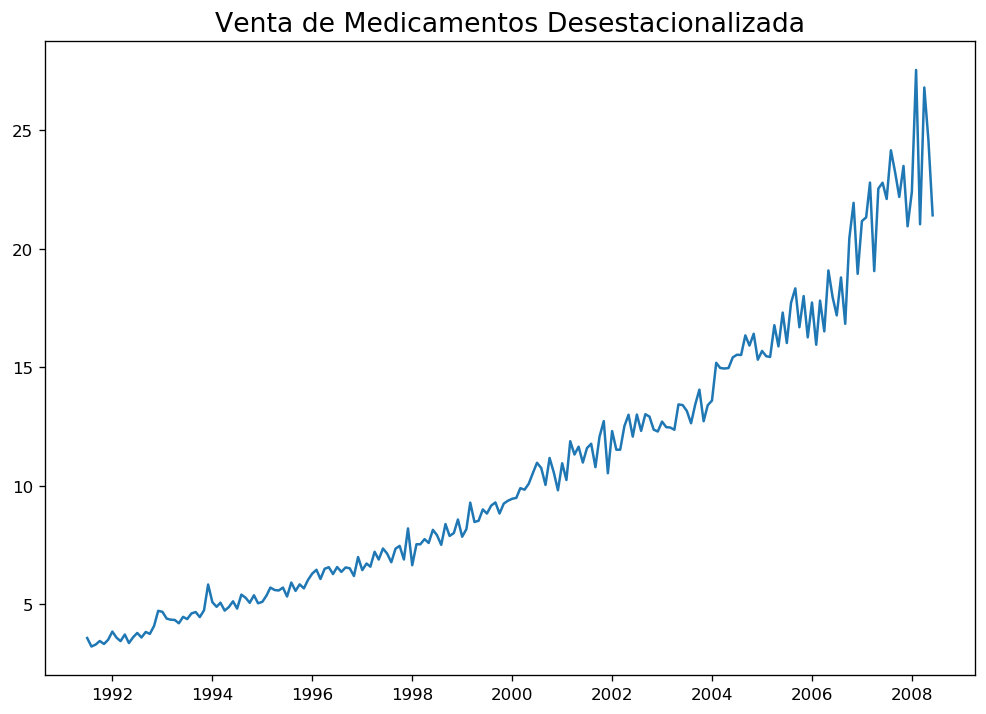

In [25]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                 parse_dates=['date'],
                 index_col='date')

### Descomposición de Serie de Tiempo
result_mul = seasonal_decompose(df['value'],
                                model='multiplicative',
                                extrapolate_trend='freq')

### Desestacionalizamos
deseasonalized = df.value.values / result_mul.seasonal

### Gráfica
plt.plot(deseasonalized)
plt.title('Venta de Medicamentos Desestacionalizada', fontsize=16)
plt.plot()

## 14. Pruebas para Estacionalidad en Series de Tiempo

La manera más común es graficar la serie y observar por patrones repetidos en periodos de tiempo fijos. Entonces, los distintos tipos de estacionalidad estarán determinados por el calendario y podrán ser:

1. Por hora
2. Día
3. Semana
4. Mes
5. Año


Si se requiere una inspección definitiva de la estacionalidad, podemos usar la gráfica de la Función de Autocorrelación (ACF).

Cuando el patrón de estacionalidad es muy marcado, la gráfica de la ACF suele revelar de manera muy puntual estos patrones estilo "onda" en las ventanas de estacionalidad.

Por ejemplo, la serie de tiempo de ventas de medicamento es una serie mensual con patrones que se repiten cada año. Por lo que podremos ver crestas en los periodos 12, 24, 36,...etc.

Es necesario recalcar que en la vida real los datos pueden ser distorsionados por el ruido, por lo cual se necesita detenida observación para captar los patrones.

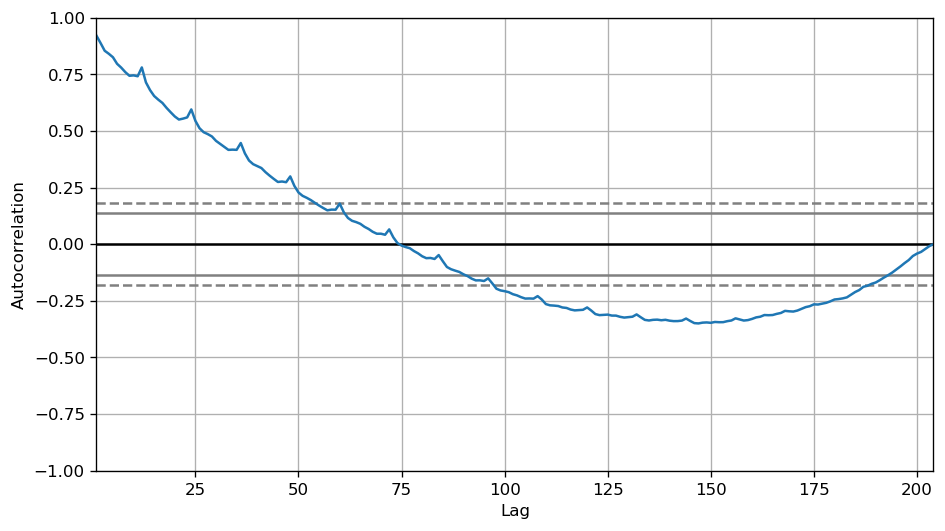

In [27]:
from pandas.plotting import autocorrelation_plot

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

### Gráfica de ACF
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df.value.tolist())

Una alternatica estadística es usar el CH Test, con el cual se puede determinar si es necesario hacer una diferencia estacional para estacionarizar la serie.

## 15. ¿Qué hacemos con los valores Missing en una Serie de Tiempo?

Es posible que nuestra serie de tiempo tenga valores faltantes en las fechas, lo cual implica que los datos no estaban disponibles o no fueron capturados para dichos periodos de tiempo. Podría ser también que el valor reportado sea en efecto 0.

Cuando trabajamos con Series de Tiempo, **no es recomendado** reemplazar valores missing con la media de la serie, especialmente si la serie es no-estacionaria. Un mejor workaround (aunque sucio, de todas formas) es llenar con el valor anterior, repitiéndolo.

Dependiendo de la naturaleza de la serie de tiempo, podemos intentar distintos approaches. Algunos muy efectivos son:

- Llenado hacia atrás

- Interpolación lineal

- Interpolación cuadrática

- Media de los valores más cercanos

- Media de las contrapartes estacionales

Para medir qué tan bueno fue el reemplazo, algo que yo hago es manualmente introducir valores missing a la serie, sustituirlos con los métodos antes mencionados y comparar el MSE de la serie con los missing reemplazados vs los valores reales.

In [ ]:
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

### Datos originales
df_orig = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                      parse_dates=['date'],
                      index_col='date').head(100)     ### Primeros 100 registros

df = pd.read_csv('/datasets/a10_missings.csv',
                 parse_dates=['date'],
                 index_col='date')

fig, axes = plt.subplots(7, 1, sharex=True, figsize=(10, 12))
plt.rcParams.update({'xtick.bottom' : False})

### 1. Actual -------------------------------
df_orig.plot(title='Datos reales', ax=axes[0], label='Datos Reales', color='red', style=".-")
df.plot(title='Datos reales', ax=axes[0], label='Datos reales', color='green', style=".-")
axes[0].legend(["Valores Missing", "Datos disponibles"])

### 2. Llenado hacia adelante --------------------------
df_ffill = df.ffill()
error = np.round(mean_squared_error(df_orig['value'], df_ffill['value']), 2)
df_ffill['value'].plot(title='Llenado hacia adelante (MSE: ' + str(error) +")", ax=axes[1], label='Llenado hacia adelante', style=".-")

### 3. Llenado hacia atrás -------------------------
df_bfill = df.bfill()
error = np.round(mean_squared_error(df_orig['value'], df_bfill['value']), 2)
df_bfill['value'].plot(title="Llenado hacia atrás (MSE: " + str(error) +")", ax=axes[2], label='Back Fill', color='firebrick', style=".-")

### 4. Interpolación Lineal ------------------
df['rownum'] = np.arange(df.shape[0])
df_nona = df.dropna(subset = ['value'])
f = interp1d(df_nona['rownum'], df_nona['value'])
df['linear_fill'] = f(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['linear_fill']), 2)
df['linear_fill'].plot(title="Interpolación Lineal (MSE: " + str(error) +")", ax=axes[3], label='Interpolación Cúbica', color='brown', style=".-")

### 5. Interpolación Cúbica --------------------
f2 = interp1d(df_nona['rownum'], df_nona['value'], kind='cubic')
df['cubic_fill'] = f2(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['cubic_fill']), 2)
df['cubic_fill'].plot(title="Interpolación Cúbica (MSE: " + str(error) +")", ax=axes[4], label='Interpolación Cúbica', color='red', style=".-")

# Referencias para interpolación:
# https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html
# https://docs.scipy.org/doc/scipy/reference/interpolate.html

### 6. Media de los 'n' valores más cercanos ------
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

df['knn_mean'] = knn_mean(df.value.values, 8)
error = np.round(mean_squared_error(df_orig['value'], df['knn_mean']), 2)
df['knn_mean'].plot(title="Media KNN (MSE: " + str(error) +")", ax=axes[5], label='Media KNN', color='tomato', alpha=0.5, style=".-")

## 7. Media Estacional ----------------------------
def seasonal_mean(ts, n, lr=0.7):
    """
    Calcula la media de los correspondientes componentes estacionales
    ts: 1D vector de la serie de tiempo
    n: Longitud de la ventana estacional de la serie de tiempo
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  ### Sólo temporadas previas
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  ### previa y subsecuente
            out[i] = np.nanmean(ts_seas) * lr
    return out

df['seasonal_mean'] = seasonal_mean(df.value, n=12, lr=1.25)
error = np.round(mean_squared_error(df_orig['value'], df['seasonal_mean']), 2)
df['seasonal_mean'].plot(title="Media Estacional (MSE: " + str(error) +")", ax=axes[6], label='Media Estacional', color='blue', alpha=0.5, style=".-")

Podemos considerar también los siguientes métodos dependiendo de la precisión requerida:

1. Si tenemos variables explicativas podemos usar modelos de predicción como *bosques aleatorios* o *k-nearest neighbors*


2. Si tenemos suficientes observaciones del pasado, podemos pronosticar los valores missing


3. Si tenemos suficientes observaciones futuras, podemos propagar hacia atrás los valores missing


4. Podemos pronosticar las contrapartes cíclicas



## 16. Funciones de Autocorrelación y Autocorrelación Parcial

La *autocorrelación* es simplemente la correlación que existe entre la serie y sus propios lags. Si una serie está significativamente autocorrelacionada, esto quiere decir que los valores previos de la serie (lags) pueden ayudarnos a dar un pronóstico del valor actual.

La *autocorrelación parcial* contiene información similar pero excluye la contribución a la correlación por parte de los lags intermedios

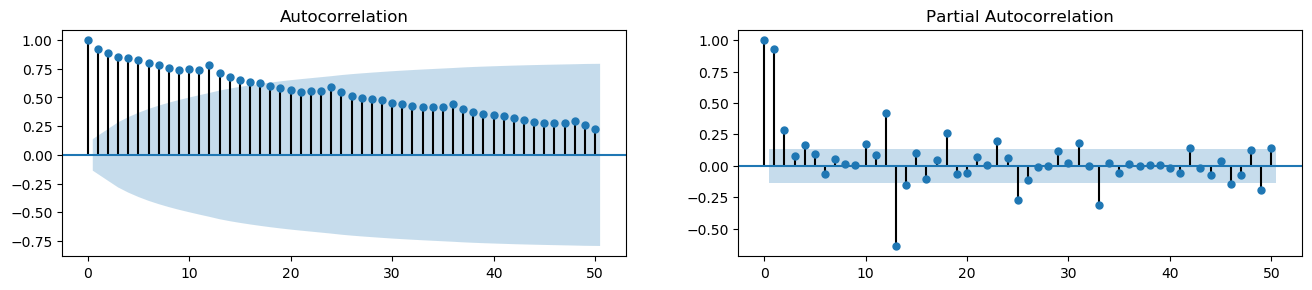

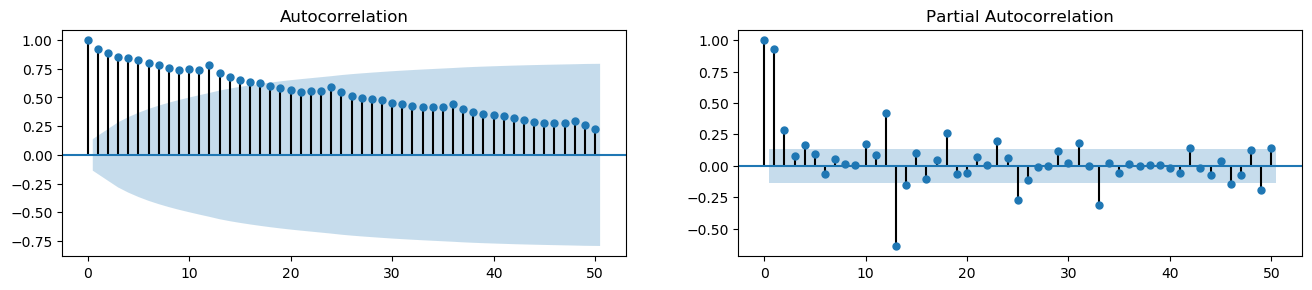

In [34]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

### Calculamos ACF and PACF para 50 lags
### acf_50 = acf(df.value, nlags=50)
### pacf_50 = pacf(df.value, nlags=50)

### Graficamos
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df.value.tolist(), lags=50, ax=axes[0])
plot_pacf(df.value.tolist(), lags=50, ax=axes[1])

## 17. ¿Cómo calcular la Función de Autocorrelación Parcial (PACF)?

La autocorrelación parcial del $lag(k)$ de una serie es el coeficiente de dicho lag en la ecuación de autoregresión de $Y$.

La ecuación autoregresiva de $Y$ no es más que la regresión lineal de $Y$ con sus propios lags como predictores.

Por ejemplo, si $Y_{t}$ es la serie en cuestión y $Y_{t-1}$ es el lag 1 de $Y$, entonces la autocorrelación parcial del lag3 ($Y_{t-3}$) es el coeficiente $\alpha_{3}$ de $Y_{3}$ en la siguiente ecuaicón:

$$ Y_{t} = \alpha_{0} + \alpha_{1}Y_{t-1} + \alpha_{2}Y_{t-2} + \alpha_{3}Y_{t-3}$$

## 18. Gráficas de Lags

Una gráfica de lag es la gráfica de dispersión de una serie de tiempo vs el lag mismo. Normalmente las usamos para buscar la autocorrelación. Si existe algún patrón en la serie (como el que veremos abajo) la serie está autocorrelacionada. 

De noe xistir dicho patrón, es muy probable que la serie sea simplemente ruido blanco.

En el siguiente ejemplo, las gráficas muestran cada vez más dispersión mientras el $lag(n)$ incrementa:

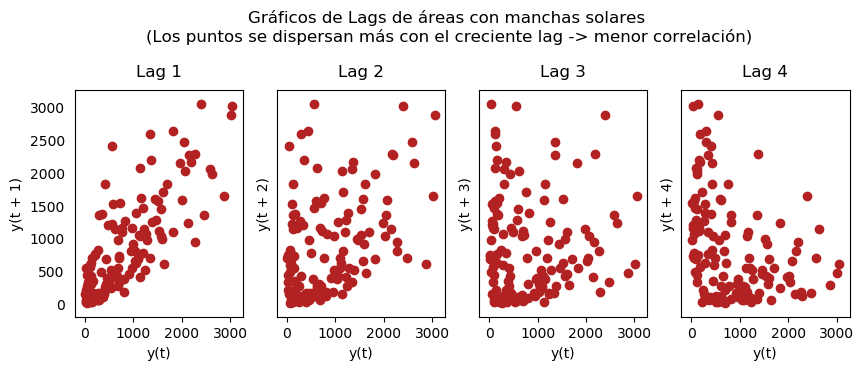

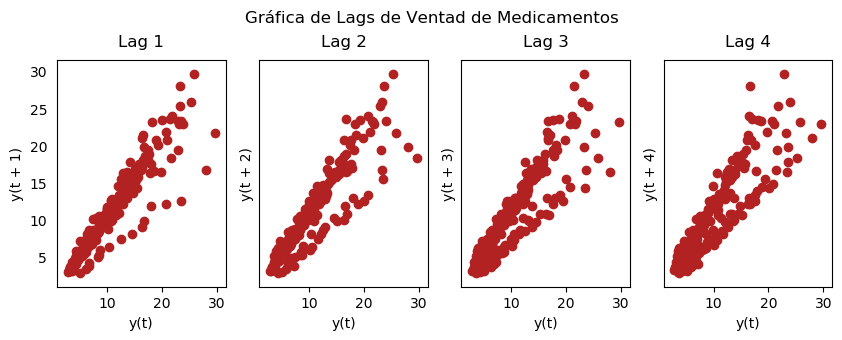

In [36]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

### Importamos datos
ss = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv')
a10 = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

### Gráfica
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(ss.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Gráficos de Lags de áreas con manchas solares \n(Los puntos se dispersan más con el creciente lag -> menor correlación)\n', y=1.15)    

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(a10.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Gráfica de Lags de Ventad de Medicamentos', y=1.05)    
plt.show()

## 19. ¿Cómo estimar la pronosticabilidad de una Serie de Tiempo?

Mientras más regulares y repetibles sean los patrones en una serie de tiempo, más fácil será pronosticarla.

La **Entropía Aproximada** puede usarse para cuantificar la regularidad e impredecibilidad de las fluctuaciones de una serie de tiempo.

Mientras más alta sea la entropía aproximada, más difícil será pronosticar.

Una mejor alternativa es la **Entropía Muestral**

La entropía muestral es similar a la aproximada pero es más consistente en estimar la complejidad incluso para series de tiempo cortas. 

Por ejemplo, una serie de tiempo aleatoria con menos datos puede tener una menor entropía aproximada que una serie de tiempo regular, mientras que una serie de tiempo larga (con muchas observaciones en el tiempo) tendrá una entropía aproximada más alta.

A continuación un ejemplo de *Entropía Aproximada*:

In [37]:
### Importamos datos
ss = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv')
a10 = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

### Declaramos vectores aleatorios
rand_small = np.random.randint(0, 100, size=36)
rand_big = np.random.randint(0, 100, size=136)

### Función de Entropía Aproximada
def ApEn(U, m, r):
    """Calcula la entropía aproximada"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

print(ApEn(ss.value, m=2, r=0.2*np.std(ss.value)))     # 0.651
print(ApEn(a10.value, m=2, r=0.2*np.std(a10.value)))   # 0.537
print(ApEn(rand_small, m=2, r=0.2*np.std(rand_small))) # 0.143
print(ApEn(rand_big, m=2, r=0.2*np.std(rand_big)))     # 0.716

0.6514704970333534
0.5374775224973489
0.0898376940798844
0.6725953850207098


Y ahora un ejemplo de *Entropía Muestral*:

In [38]:
def SampEn(U, m, r):
    """Calcula la entropía muestral"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(ss.value, m=2, r=0.2*np.std(ss.value)))      # 0.78
print(SampEn(a10.value, m=2, r=0.2*np.std(a10.value)))    # 0.41
print(SampEn(rand_small, m=2, r=0.2*np.std(rand_small)))  # 1.79
print(SampEn(rand_big, m=2, r=0.2*np.std(rand_big)))      # 2.42

0.7853311366380039
0.41887013457621214
inf


C:\Users\SANTICA4\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


2.2721258855093374


## 20. ¿Cuándo y cómo suavizar una Serie de Tiempo?

Suavizar una serie de tiempo es útil si:

- Queremos reducir el efecto del ruido en una señal y así obtener una buena aproximación de la serie filtrada contra el ruido

- La versión suavizada de la serie puede ser usada para explicar a la serie misma.

- Visualizar mejor la tendencia

Entonces, ¿Cómo suavizar una serie de tiempo? A continuación algunos métodos:

1. Tomar las medias móviles


2. Hacer un suavizamiento LOESS (Regresión Localizada)


3. Hacer un suavizamiento LOWESS (Regresión Localmente Ponderada)

Las medias móviles no son mas que el promedio de un intervalo móvil de determinado tamaño. Lo importante es escoger bien el tamaño del intervalo, pues un intervalo grande sobre-suavizará la serie.

Por ejemplo, una ventana del mismo tamaño que la duración de la estacionalidad (12 para una serie mensual) hará nulo el efecto estacional.

LOESS, versión corta de "LOcalized regrESSion", ajusta multiples regresiones en la vecindad local de cada punto. En Python está implementada en la paquetería de *statsmodels*, ahí podemos controlar el grado de suavizamiento usando *frac*, el cual especifica el porcentaje de puntos cercanos que deben ser considerados para ajustar un modelo de regresión.

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

### Importamos datos
df_orig = pd.read_csv('datasets/elecequip.csv',
                      parse_dates=['date'],
                      index_col='date')

### 1. Medias Móviles
df_ma = df_orig.value.rolling(3, center=True, closed='both').mean()

### 2. Suavizamiento LOESS (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(df_orig.value,
                                 np.arange(len(df_orig.value)),
                                 frac=0.05)[:, 1], index=df_orig.index, columns=['value'])
df_loess_15 = pd.DataFrame(lowess(df_orig.value,
                                  np.arange(len(df_orig.value)),
                                  frac=0.15)[:, 1], index=df_orig.index, columns=['value'])

### Gráfica
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
df_orig['value'].plot(ax=axes[0], color='k', title='Serie Original')
df_loess_5['value'].plot(ax=axes[1], title='Suavizamiento LOESS al 5%')
df_loess_15['value'].plot(ax=axes[2], title='Suavizamiento LOESS al 15%')
df_ma.plot(ax=axes[3], title='Media Móvil (3)')
fig.suptitle('Cómo Suavizar una Serie de Tiempo', y=0.95, fontsize=14)
plt.show()

## 21. Prueba de Causalidad de Granger para saber si una Serie de Tiempo es buena para pronosticar otra

¿Cómo funciona esta prueba?

Se basa en la idea de que si $X$ causa $Y$, entonces el forecast de $Y$ basado en valores previos de $Y$ y en valores previos de $X$ debe ser mejor que el forecast de $Y$ basado en valores previos de $Y$ solamente.

Entendamos entonces que la Prueba de Causalidad de Granger no debe usarse para comprobar si un lag de $Y$ causa $Y$, más bien debe usarse para saber si una variable externa $X$ es causante de $Y$.

Nuevamente hay una muy buena implementación en el paquete de *statsmodel*

Toma como argumento una vector 2-dimensional con 2 columnas como el argumento principal. Los valores están en la primera columna y el predictor ($X$) es la segunda columna.

La hipótesis nula es:

- La serie en la 2a columna no es causante (vía Granger) de la serie en la primera columna.

Si los *p-values* son **menores** al nivel de significancia (0.05) entonces rechazamos $H_{0}$ y concluimos que el lag de $X$ nos sirve para pronosticar.

El 2o argumento *maxlag* indica cuantos lags de $Y$ deben ser incluidos en la prueba

In [43]:
from statsmodels.tsa.stattools import grangercausalitytests

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                 parse_dates=['date'])
df['month'] = df.date.dt.month
grangercausalitytests(df[['value', 'month']], maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=54.7797 , p=0.0000  , df_denom=200, df_num=1
ssr based chi2 test:   chi2=55.6014 , p=0.0000  , df=1
likelihood ratio test: chi2=49.1426 , p=0.0000  , df=1
parameter F test:         F=54.7797 , p=0.0000  , df_denom=200, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=162.6989, p=0.0000  , df_denom=197, df_num=2
ssr based chi2 test:   chi2=333.6567, p=0.0000  , df=2
likelihood ratio test: chi2=196.9956, p=0.0000  , df=2
parameter F test:         F=162.6989, p=0.0000  , df_denom=197, df_num=2


{1: ({'ssr_ftest': (54.779674835573566, 3.6614258713531555e-12, 200.0, 1),
   'ssr_chi2test': (55.60136995810717, 8.876175235021637e-14, 1),
   'lrtest': (49.14260233004984, 2.38014300604565e-12, 1),
   'params_ftest': (54.77967483557362, 3.6614258713530505e-12, 200.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (162.6989179987325, 1.913323508685587e-42, 197.0, 2),
   'ssr_chi2test': (333.65666432227374, 3.5267600881275606e-73, 2),
   'lrtest': (196.9955927718221, 1.670900349911483e-43, 2),
   'params_ftest': (162.69891799873255, 1.9133235086855594e-42, 197.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

En este caso, los *p-values* son 0 para todas las pruebas. Entonces el mes en cuestión puede ser usado para pronosticar.

## 22. Ya entendemos Series de tiempo, ¿Y ahora qué?

Una vez que el análisis de series de tiempo se hizo, lo siguiente es hacer forecasts.

En la siguiente sección detallaré como construir el **Modelo ARIMA** para forecasting de Series de Tiempo.

# Modelo ARIMA 

# Guía completa para Forecasting de Series de Tiempo en Python

Usando el modelo ARIMA, pdoemos pronosticar una serie de tiempo usando sus valores anteriores. Nuestro objetivo es construir un modelo ARIMA óptimo desde cero y extenderlo a un modelo ARIMA Estacional (SARIMA & SARIMAX). También construiré un modelo AUTO-ARIMA en Python.

## 1. Introducción al Forecasting de Series de Tiempo

¿Por qué pronosticar?

- Pronosticar una serie de tiempo (como lo son la demanda y las ventas) tiene un valor comercial muy alto.

- Las compañías toman decisiones y plantean estrategias basadas en forecasts.

- Por esto es importante que los pronósticos sean precisos

El forecasting en Series de Tiempo se divide, a grandes razgos, en dos tipos:

- Si sólo usamos los valores previos de la serie para predecir valores futuros, entocnes hablamos de un **Forecasting Univariado de Series de Tiempo**


- Y si usamos predictores adicionales a la serie misma (conociddos como *variables exógenas*) para hacer el pronóstico hablaremos de **Forecasting Multivariado de Series de Tiempo**

ARIMA es acrónimo de "AutoRegressive Integrated Moving Average", se trata de un algoritmo de forecasting que se basa en en la idea de que la información de los valores pasados en la serie puede por si sola servir para predecir los valores futuros.

Cualquier serie no-estacional que tenga patrones y que no sea ruido blanco puede ser modelada usando un modelo ARIMA.

Un modelo ARIMA se caracteriza por 3 parámetros: $p, d, q$, donde:

- $p$ es el orden del término AR


- $q$ es el orden del término MA


- $d$ es el número de diferenciaciones requeridas para volver la serie de tiempo estacionaria

Si una serie de tiempo tiene patrones estacionales, entonces necesitamos añadir términos estacionales y se convierte en un modelo SARIMA.

¿Qué quiere decir entonces "orden del término AR"? Para definirlo, primero necesitamos entender el parámetro $d$

## 3. ¿Qué significan los parámetros $p, d$ y $q$ en el modelo ARIMA?

El primer paso para construir un modelo ARIMA es volver a la serie estacionaria, ¿Por qué?

Porque el término "Auto Regresivo" en ARIMA quiere decir que es un **modelo de regresión lineal** que usa sus propios lag como predictores. Los modelos de regresión lineal funcionan mejor cuando los predictores no están correlacionados y son independientes uno del otro.

Recordemos que un método para estacionarizar una serie de tiempo es la diferenciación entre $t$ y $t-1$, a veces más diferenciaciones son necesarias. 

Entonces, el valor de $d$ es el **mínimo número de diferenciaciones necesarias** para que la serie se transforme en estacionaria. Si la serie de tiempo ya es estacionaria, entonces $d = 0$

Ahora, ¿Qué son los términos $p$ y $q$?

$p$ es el orden del término AR, se refiere al número de lags de $Y$ que serán usados como predictores. Por otro lado, $q$ es el orden del término MA y serefiere al numero de errores "lagueados" del forecast que deberán incluirse en el modelo ARIMA.

## 4. ¿Qué son los modelos AR y MA?


Un modelo **puramente autoregresivo** (AR only) es aquel en el que $Y_{t}$ depende sólo de sus propios lags. Es decir, $Y_{t}$ es una función de los lags de $Y_{t}$:

$$Y_{t} = \alpha + \beta_{1}Y_{t-1} + \beta_{2}Y_{t-2} + ... + \beta_{p}Y_{t-p} + \epsilon_{1}$$

donde $Y_{t-1}$ es el lag1 de la serie, $\beta_{1}$ es el coeficiente del lag1 estimado por el modelo y $\alpha$ es el término del intercepto, tambié estimado por el modelo.

Análogamente, un modelo **puramente de medias móviles** (MA only) es aquel en que $Y_{t}$ depende exclusivamente de los errores "lagueados" del forecast:

$$Y_{t} = \alpha + \epsilon_{t} + \phi_{1}\epsilon_{t-1} + \phi_{2}\epsilon_{t-2} + ... + \phi_{q}\epsilon_{t-q}$$

donde los términos de error son los errores de los modelos autoregresivos de los respectivos lags. Los errores $\epsilon_{t}$ y $\epsilon_{t-1}$ son los errores de las siguientes ecuaciones:

$$Y_{t} = \beta_{1}Y_{t-1} + \beta_{2}Y_{t-2} + ... + \beta_{0}Y_{0} + \epsilon_{t}$$


$$Y_{t-1} = \beta_{1}Y_{t-2} + \beta_{2}Y_{t-3} + ... + \beta_{0}Y_{0} + \epsilon_{t-1}$$

Esos son los modelos AR y MA respectivamente, entonces, matemáticamente, ¿Cómo se ve un modelo ARIMA?

Un modelo ARIMA será aquel en el que la serie de tiempo fue diferenciada al menos una vez para volverla estacionaria, combinando así los términos de AR y MA. La ecuación resultante es:

$$Y_{t} = \alpha + \beta_{1}Y_{t-1} + \beta_{2}Y_{t-2} + ... + \beta_{p}Y_{t-p} + \epsilon_{t} + \phi_{1}\epsilon_{t-1} + \phi_{2}\epsilon_{t-2} + ... + \phi_{q}\epsilon_{t-q}$$

El modelo ARIMA en palabras es:

**$Y_{t}$ pronosticada = Constante + Combinación lineal de Lags de $Y$ (hasta $p$ lags) + Combinación Lineal de errores "lagueados" de los forecasts (hasta $q$ lags)**

Nuestro objetivo entonces es identificar los parámetros $p, d$ y $q$, ¿pero cómo?

Empecemos por encontrar el valor de $d$

## 5. Cómo encontrar el orden de diferenciación ($d$) en el modelo ARIMA

Debemos ser cuidadosos en no sobre-diferenciar la serie, pues esta podría ser estacionaria pero ya no reflejaría la realidad

¿Cómo saber que encontramos el valor óptimo de $d$?

Este será el valor mínimo de diferenciación requerido para obtener una serie cuasi-estacionaria que se mueva alrededor de una media predefinida y que la gráfica de la ACF alcance al 0 muy rápido.

Si las autocorrelaciones son positivas para varios lags (10 o más), entonces la serie necesita más diferenciaciones. Por otro lado, si la correlación del lag1 por si sola es muy negativa, entonces la serie probablemente ha sido sobre-diferenciada.

En caso de que sea muy complicado decidir entre dos posibles valores de $d$, debemos escoger el valor que obtenga la menor desviación estándar en la serie diferenciada.

A continuación lo haremos con un ejemplo.

Primero, debemos verificar que la serie sea estacionaria usando la Prueba Aumentada de Dickey-Fuller (*adfuller()*) del paquete *statsmodels*.

¿Por qué?

Porque necesitamos diferenciar la serie sólo si esta es no-estacionaria. De lo contrario, no es necesario diferenciar y esto implica que $d = 0$.

La hipótesis nula del ADF Test es que la serie de tiempo es no-estacionaria. Entonces, si el *p-value* de la prueba es **menor** que el nivel de significancia (0.05) **rechazamos $H_{0}$** e inferimos que **la serie es estacionaria**

De modo que en este caso, si $pvalue > 0.05$ proseguimos y encontramos el valor de $d$

In [44]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(df.value.dropna())
print('Estadístico ADF: %f' % result[0])
print('p-value: %f' % result[1])

Estadístico ADF: 3.145186
p-value: 1.000000


Como el *p-value* es mayor al nivel de significancia, entocnes necesitamos diferenciar la serie y visualizar la gráfica de la función de autocorrelación:

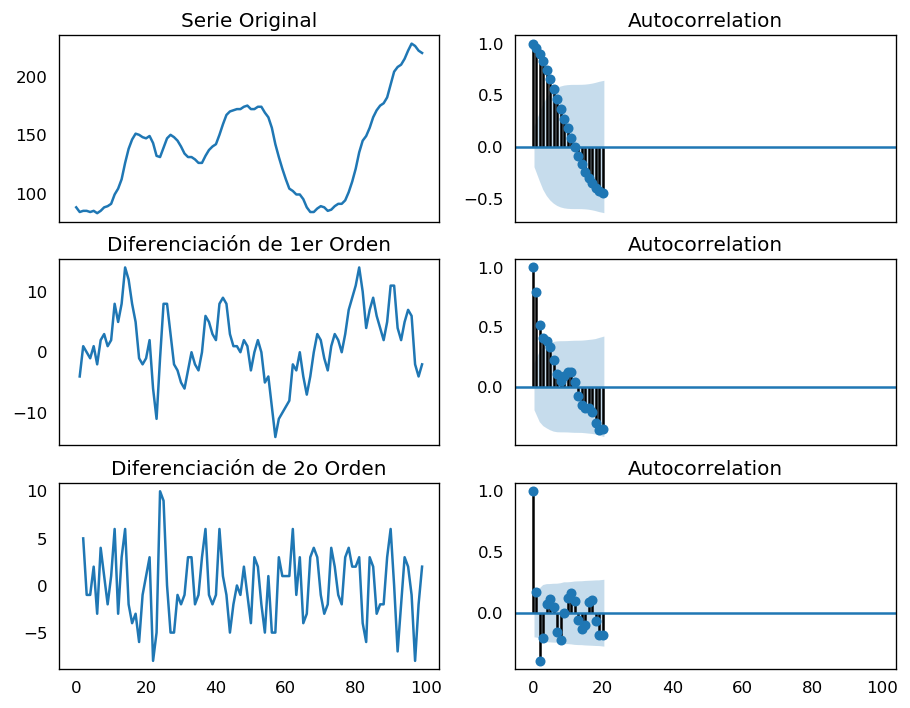

In [45]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

### Importamos datos
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv',
                 names=['value'],
                 header=0)

### Serie Original
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Serie Original')
plot_acf(df.value, ax=axes[0, 1])

### 1a Diferenciación
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('Diferenciación de 1er Orden')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

### 2a Diferenciación
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('Diferenciación de 2o Orden')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

Para la serie anterior, notemos que la serie alcanza la estacionariedad con diferenciación de 2o orden, pero si observamos la gráfica de la función de autocorrelación de dicha diferenciación, notamos que el lag se va muy rápido a la zona negativa, lo cual también indica que la serie pudo haber sido sobre-diferenciada.

Entonces, tentativamente tomaré el orden de diferenciación como 1 aun cuando la serie no es perfectamente estacionaria (estacionariedad débil)

In [49]:
from pmdarima.arima.utils import ndiffs

### Importamos datos
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv',
                 names=['value'],
                 header=0)
y = df.value

### Adf Test
ndiffs(y, test='adf')  # 2

### KPSS test
ndiffs(y, test='kpss')  # 0

### PP test:
ndiffs(y, test='pp')  # 2

2

Nótese que el código anterior nos indica el número de diferenciaiones necesarias

## 6. Cómo encontrar el orden del término AR ($p$)

El siguiente paso es identificar si el modelo necesita algún término AR. Podemos encontrar el número requerido de AR inspeccionando la gráfica de la Función de Autocorrelación Parcial (PACF).

La Función de Autocorrelación Parcial nos dirá la correlación "pura" entre un lag y la serie, de este modo sabremos si dicho lag es necesario en el término de AR o no.

¿Cómo encontramos el número de términos AR?

Cualquier autocorrelación en una serie estacionaria puede ser rectificada añadiendo suficientes términos AR. Así que inicialmente tomamos el orden del término AR igual a tantos lags crucen el límite de significancia en la gráfica de PACF.

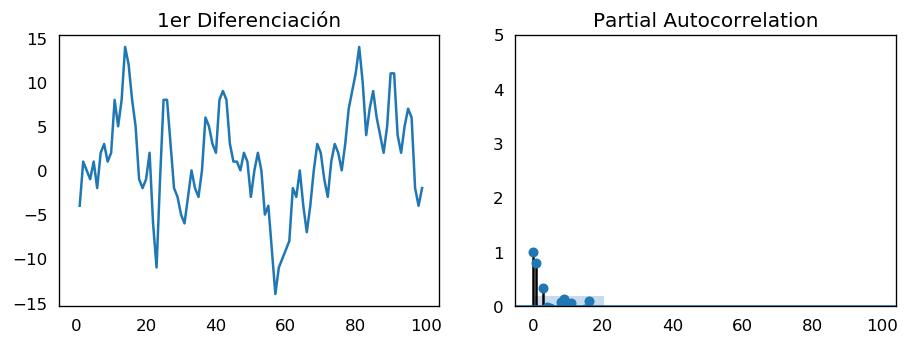

In [50]:
### Gráfica PACF de la serie diferenciada 1 vez
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1er Diferenciación')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

Observamos que el lag1 es muy significativo puesto que se encuentra muy por arriba de la linea de significancia. El lag2 también es significativo, pero apenas sobrepasa la linea (región azúl). Seré conservador y fijaré el valor de $p$ en 1

## 7. Cómo encontrar el orden del término MA ($q$)

Tal y como utilizamos la gráfica de PACF para encotnrar el número de términos AR, podemos usar ahora la gráfica de ACF para encontrar el número de términos de MA. Un término de MA  es tecnicamente el error del forecast "lagueado"

La ACF nos firá cuantos términos MA serán necesarios para remover cualquier autocorrelación en la serie estacionaria.

Visualicemos entonces la gráfica:

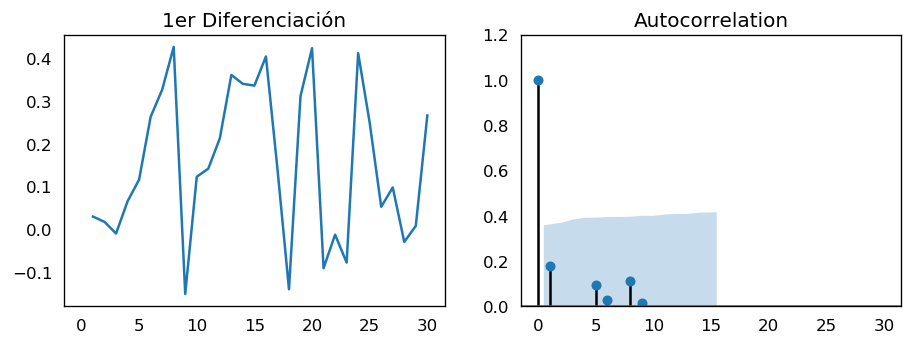

In [51]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

### Importamos datos
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/austa.csv')

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1er Diferenciación')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

## 8. ¿Qué hacer en caso de que una Serie de Tiempo esté ligeramente sobre o sub-diferenciada?

Si la serie está ligeramente sub-diferenciada, podemos solucionarlo sumando uno o más términos AR. Similarmente, si la serie está ligeramente sobre-diferenciada, intenta añadir un término MA adicional.

## 9. Construyendo el Modelo ARIMA

Una vez conseguidos los valores $p, d$ y $q$, ya tenemos todo lo necesario para ajustar el modelo ARIMA. Podemos usar la implementación *ARIMA()* del paquete *statsmodels*:

In [55]:
from statsmodels.tsa.arima_model import ARIMA

### 2,1,1 ARIMA 
model = ARIMA(df.value, order=(2,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   30
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  10.924
Method:                       css-mle   S.D. of innovations              0.168
Date:                Sat, 08 Feb 2020   AIC                            -11.848
Time:                        23:11:32   BIC                             -4.842
Sample:                             1   HQIC                            -9.607
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1588      0.027      5.907      0.000       0.106       0.212
ar.L1.D.value     0.5871      0.560      1.049      0.304      -0.510       1.684
ar.L2.D.value    -0.3156      0.185     

El output del modelo nos da mucha información. La tabla en el medio son los coeficientes en los cuales la columna "coef" son las ponderaciones de los respectivos términos.

Es importante recordar que:

- El objetivo es encontrar el valor más reducido de AIC posible

- Tener p-values de ARn, MAn significativos (<< 0.05)

- Graficar los residuales para verificar que no hay patrones (i.e. buscar media y varianza constantes)

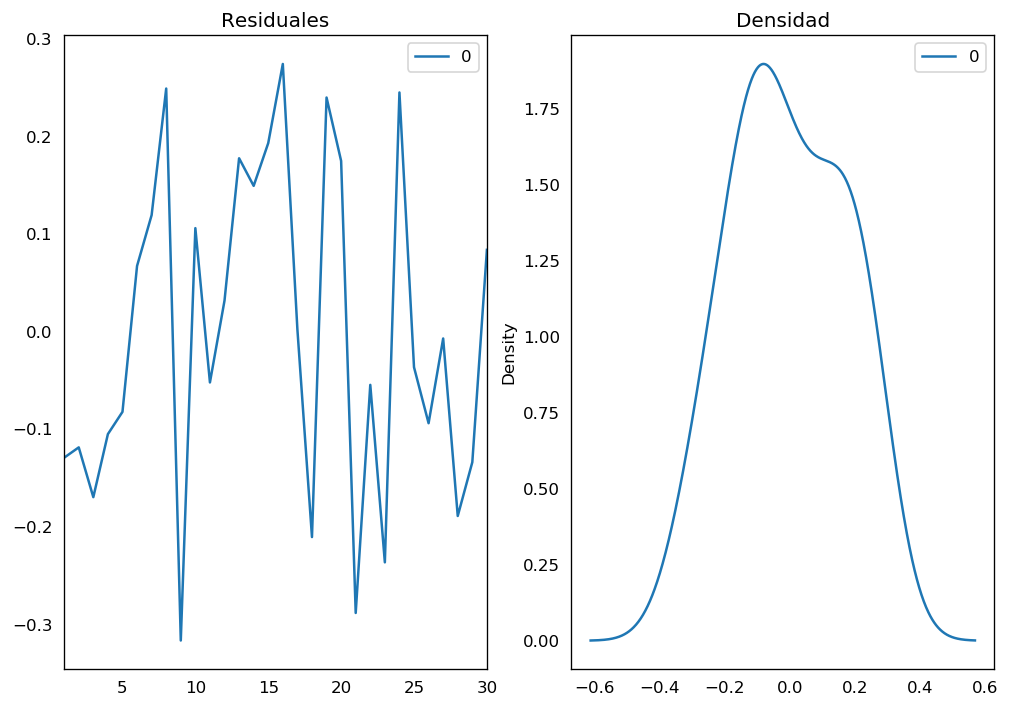

In [56]:
### Graficamos los residuales
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuales", ax=ax[0])
residuals.plot(kind='kde', title='Densidad', ax=ax[1])
plt.show()

Los errores residuales parecen buenos con media cercana al cero y varianza uniforme. Grafiquemos los valores reales contra los ajustados con *plot_predict()*

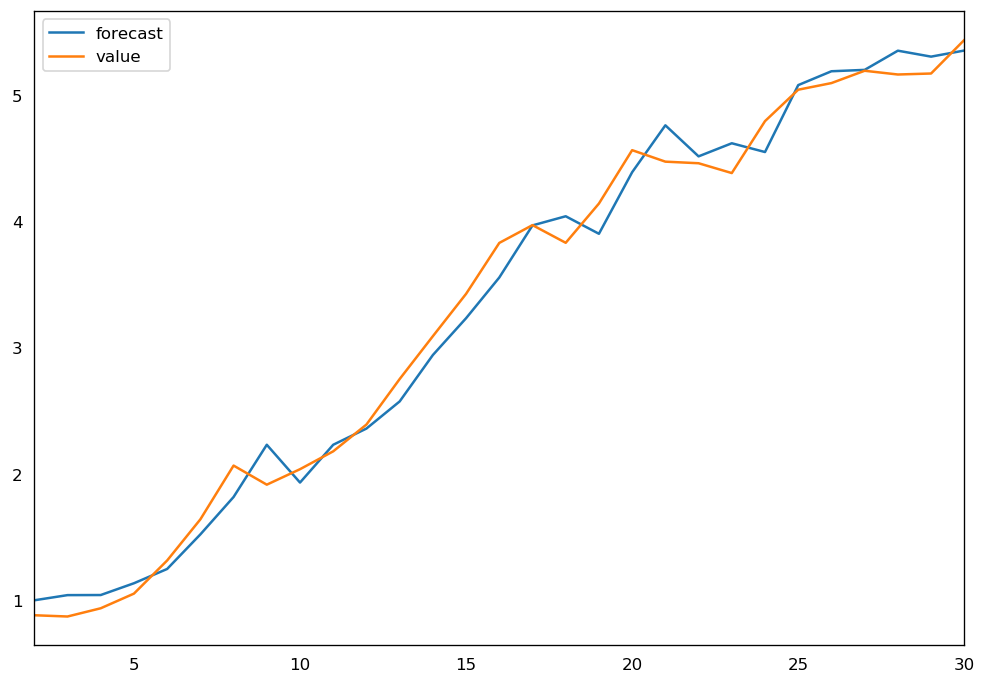

In [57]:
# Actual vs Ajustado
model_fit.plot_predict(dynamic=False)
plt.show()

Cuando usamos *dynamic=False* los valores lagueados son usados para la predicción.

Esto quiere decir que el modelo se entrena hasta el valor previo para hacer la siguiente predicción. Esto puede hacer que el pronóstico ajustado y los valores reales se vean artificialmente bien.

Pareciera ser que tenemos un ARIMA decente, pero, ¿es el mejor?

Por ahora no podemos decirlo porque no hemos hecho ningún forecast hacia el futuro aun y por lo tanto no lo hemos comparado con el desempeño real.

Entonces, la validación que necesitamos ahora es la **Validación Cruzada Fuera de Tiempo**

## 10. ¿Cómo obtener el ARIMA óptimo manualmente usando Validación Cruzada Fuera de Tiempo?

Esto consiste en "dar unos pasos hacia atrás" en el tiempo y pronosticar hacia el futuro dichos pasos. Entonces comparamos el forecast con los valores actuales.

Para realizar esta validación es necesario crear los conjuntos de entrenamiento y de prueba partiendo la serie de datos en 2 partes contiguas a razón de aproximadamente 75:25 (tema a tratar a parte por la complejidad, pero tomaremos esta proporción como baseline).

¿Por qué no muestreo la data para entrenamiento de manera aleatoria?

Esto es porque en series de tiempo el orden de la secuencia debe estar intacto para ser usado en el forecast.

In [88]:
from statsmodels.tsa.stattools import acf

### Importamos datos
df = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/WWWusage.csv')

### Creamos data de entrenamiento y prueba
train = df.value[:85]
test = df.value[85:]

Ahora construimos el modelo ARIMA sobre la data de entrenamiento, hacemos el forecast y lo graficamos:

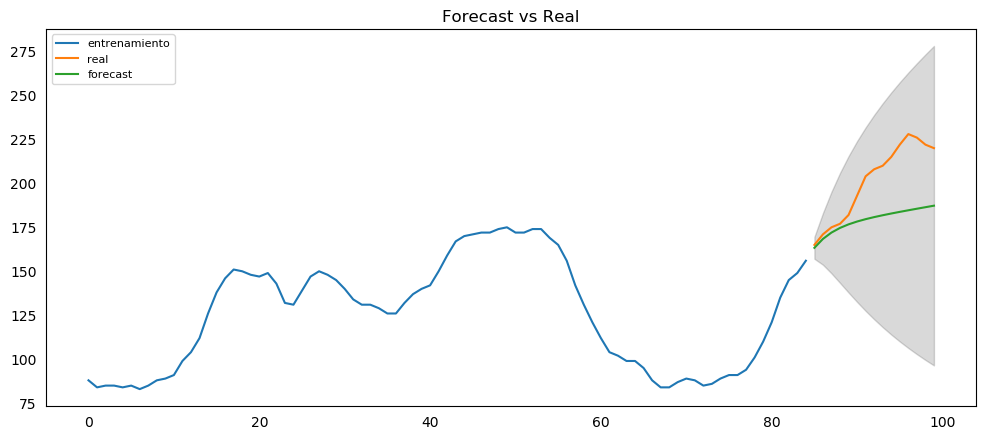

In [89]:
### Construimos el modelo
### modelo = ARIMA(entrenamiento, orden=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

### Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

### Formateamos como serie de Pandas
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

### Grpafica
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='entrenamiento')
plt.plot(test, label='real')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Real')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Es importante prestar atención a lo siguiente:

- Nuestro forecast parece tener la direccionalidad correcta y los valores reales se encuentran dentro de la banda de 95% de confianza, lo cual es bueno.


- Pero cada uno de los valores pronósticados es consistentemente menos que los reales. Esto quiere decir que añadiendo una pequeña constante a nuestro forecast la precisión aumentará. Hay lugar para mejoras.


- Lo que haré ahora será aumentar el orden de diferenciación a 2, es decir $d = 2$ e iterativamente incrementar $p$ hasta 5 y luego $q$ hasta 5 para ver qué modelo me da el menor AIC y también ver qué gráfico acerca más el forecast a los valores reales.


- Mientras hago esto, vigilaré los *p-values* de los términos AR y MA en el resumen del modelo. Deben ser lo ás cercano posible a 0, idealmente menores a 0.05

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   83
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -214.248
Method:                       css-mle   S.D. of innovations              3.153
Date:                Sun, 09 Feb 2020   AIC                            440.497
Time:                        10:13:40   BIC                            455.010
Sample:                             2   HQIC                           446.327
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0483      0.084      0.577      0.565      -0.116       0.212
ar.L1.D2.value     1.1386      0.109     10.399      0.000       0.924       1.353
ar.L2.D2.value    -0.5923      0.155

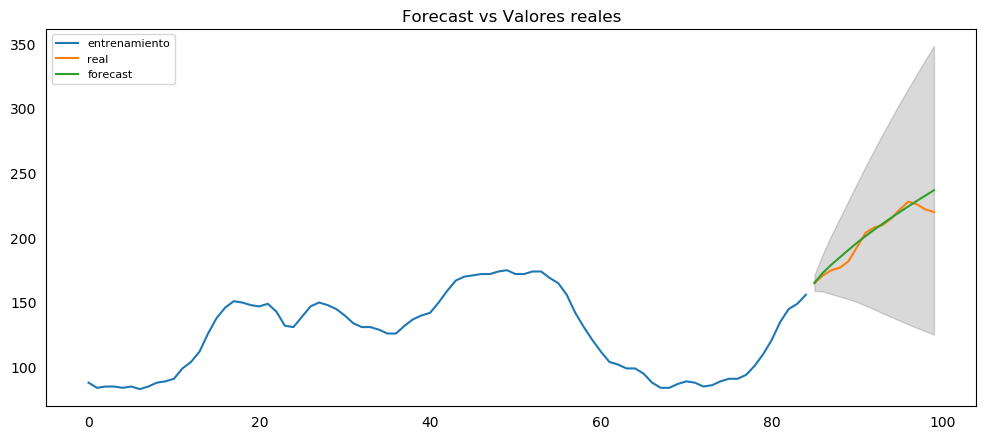

In [90]:
### Construimos modelo
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

### Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

### Formateamos como serie de pandas
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

### Gráfica
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='entrenamiento')
plt.plot(test, label='real')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Valores reales')
plt.legend(loc='upper left', fontsize=8)
plt.show()

El AIC se redujo de 515 a 440 lo cual es bueno. Los *p-values* de $X$ son menores a 0.05 lo cual es muy bueno.

En general, ésta es una mucho mejor parametrización

Idealmente deberíamos regresar varios periodos en el tiempo, poer ejemplo 1, 2, 3 o 4 trimestres y observar el forecast para dichos periodos.

Algo que podemos hacer para practicar es lo siguiente: vayamos hacia atrás 27, 30, 33 y 36 puntos para ver cómo se comporta el forecast. El desempeño del forecast puede juzgarse a través de distintas métricas que discutiremos a continuación.

## 11. Métricas de Precisión para Forecasts de Series de Tiempo

Los más comunes son:

1. Porcentaje de Error Absoluto de la Media (MAPE)

2. Error Medio (ME)

3. Error Absoluto Medio (MAE)

4. Error Porcentual Medio (MPE)

5. Raíz Cuadrada del Error Medio (RMSE)

6. Error de Autocorrelación de Lag1 (ACF1)

7. Correlación entre los valores reales y el forecast (corr)

8. Error Mínimo y Máximo (minimax)

Típicamente, si estamos comparando forecasts de dos series distintas, MAPE, corr y minimax pueden usarse.

¿Por qué no usar las otras métricas?

Porque sólo los tres mencionados antes son errores porcentuales que varían entre 0 y 1. De este modo podemos juzgar qué tan bueno es el forecast independientemente de la escala de nuestros datos.

Las otras métricas en realidad son cantidades. Esto quiere decir que un RMSE de 100 para una serie con media en los 1000's e mejor que un RMSE de 5 para una serie con media en los 10's. Así que no podemos usarlas para comparar forecasts de series con diferente escala.

In [75]:
### Métricas de Precisión
def forecast_accuracy(forecast, actual):
    '''
    param: forecast
    param: actual
    '''
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

ValueError: operands could not be broadcast together with shapes (15,) (0,) 

Un MAPE de 2.2% implica que el modelo es 97.8% preciso en predecir las siguientes 15 observaciones. 

Ahora ya sabemos cómo construir un modelo ARIMA de forma manual.

Pero, en la vida real, tendremos muchas series de tiempo a pronosticar, poco tiempo y será un ejercicio que se repetirá con regularidad.

Entonces necesitamos una manera de automatizar el proceso de selección del mejor modelo.

## 12. Cómo hacer un Auto ARIMA Forecast en Python

El lenguaje de programación R tiene una función muy conocida (*auto.arima()*), nosotros estamos usando el lenguaje Python. Afortunadamente, el paquete *pmdarima* provee una función *auto_arima()* muy similar.

Esta función usa un procesos por pasos para buscar múltiples combinaciones de los parámetros $p, d$ y $q$ y escoge el mejor modelo que tenga el menor AIC:

In [77]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv',
                 names=['value'],
                 header=0)

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       ### usa adftest para encontrar 'd' óptima
                      max_p=3, max_q=3, ### máxima p y q
                      m=1,              ### frecuencia de la serie
                      d=None,           ### dejamos que el modelo determine 'd'
                      seasonal=False,   ### Sin estacionalidad
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 0); AIC=525.587, BIC=535.926, Fit time=0.120 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=533.474, BIC=538.644, Fit time=0.011 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=532.437, BIC=540.192, Fit time=0.036 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 0); AIC=525.893, BIC=533.648, Fit time=0.036 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=531.477, BIC=534.062, Fit time=0.016 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 0, 0, 0); AIC=515.248, BIC=528.173, Fit time=0.084 seconds
Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=513.459, BIC=523.799, Fit time=0.049 seconds
Fit ARIMA: order=(3, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=515.284, BIC=528.209, Fit time=0.089 seconds
Fit ARIMA: order=(3, 2, 1) seasonal_order=(0, 0, 0, 0); AIC=512.556, BIC=528.066, Fit time=0.536 seconds
Near non-invertible roots for order (3, 2, 1)(0, 0, 0, 

## 13. Interpretando las Gráficas Residuales del Modelo ARIMA

Podemos ver las gráficas residuales usando la función *stepwise_fit* 

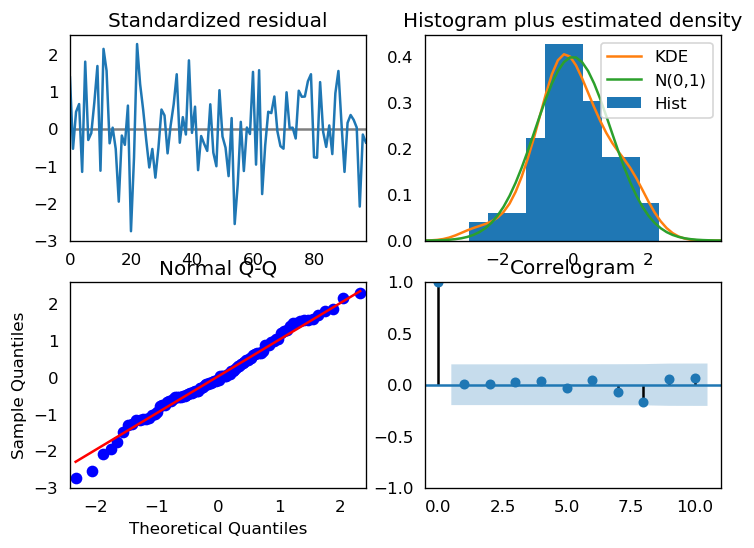

In [78]:
model.plot_diagnostics(figsize=(7, 5))
plt.show()

¿Cómo interpretamos estos 4 gráficos?

**Superior izquierdo:** Los errores residuales parecen fluctuar al rededor de la media de 0 y tienen varianza uniforme.

**Superior derecho:** La gráfica de densidad sugiere que se distribuyen normal con media 0.

**Inferior izquierdo:** Todos los puntos deben caer perfectamente sobre la linea roja. Cualquier desviación visible implicará que la distribución tiene sesgo.

**Inferior derecha:** El Correlograma, aka ACF nos muestra que los errores residuales no están correlacionados. Cualquier autocorrelación implicaría que existe aún algún patrón en los errores residuales que no está explicado en el modelo. Entonces necesitaríamos buscar más $X's$ (predictores) para el modelo.

En este caso, tenemos un buen ajuste, así que hagamos el forecast.

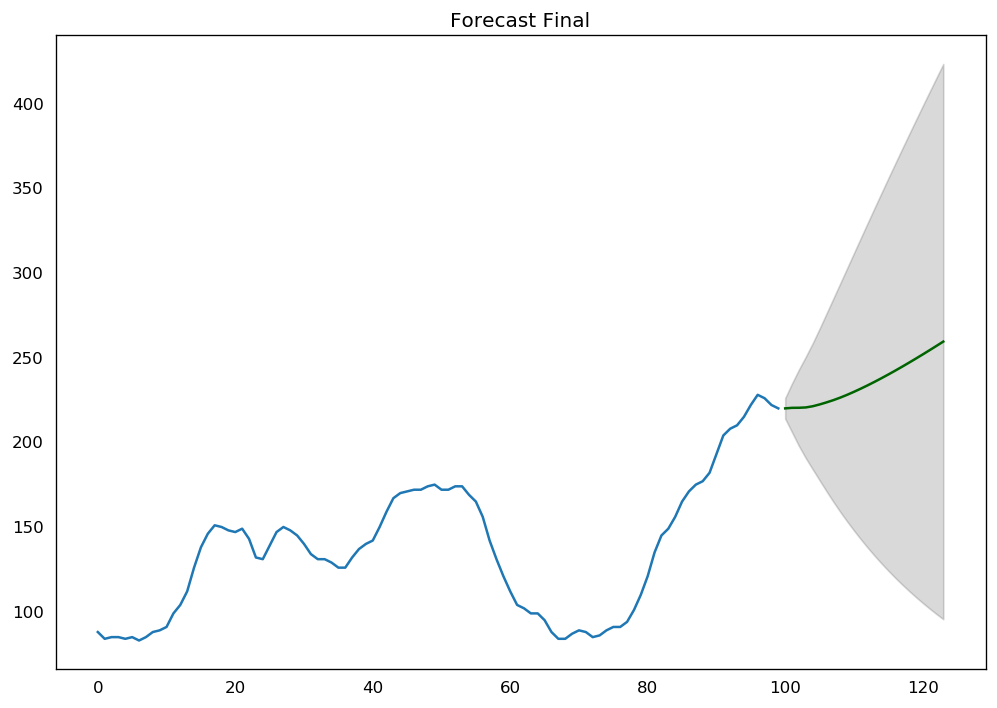

In [79]:
### Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

### Creamos serie para graficar
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

### Gráfica
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Forecast Final")
plt.show()

## 14. Construyendo automáticamente el Modelo SARIMA en Python

El problema con el modelo ARIMA es que no es compatible cuando hay estacionalidad.

Si nuestra serie de tiempo tiene estacionalidad, entonces debemos usar el modelo SARIMA porque usa diferenciación estacional.

La diferenciación estacional es muy similar a la diferenciación normal, sólo que en vez de restar términos consecutivos, restamos términos de la temporada anterior. 

De modo que el modelo será representado como SARIMA($p, d, q$) x ($P,D,Q$), donde $P, D$ y $Q$ son términos para SAR, orden de diferenciación estacional y SMA respectivamente. $x$ será la frecuencia de la serie de tiempo.

Si nuestro modelo tiene patrones estacionalidades bien definidos, entoonces forzaremos $D=1$ para una frecuencia dada $x$.

A continuación algunos consejos para construir un modelo SARIMA:

Una regla general es poner los parámetros de tal manera que $D$ jamás exceda 1. El total de la diferencia $d + D$ nunca exceda de 2. Intenta mantener sólamente SAR o SMA si tu modelo tiene componente estacional.

Construiremos ahora un modelo SARIMA:

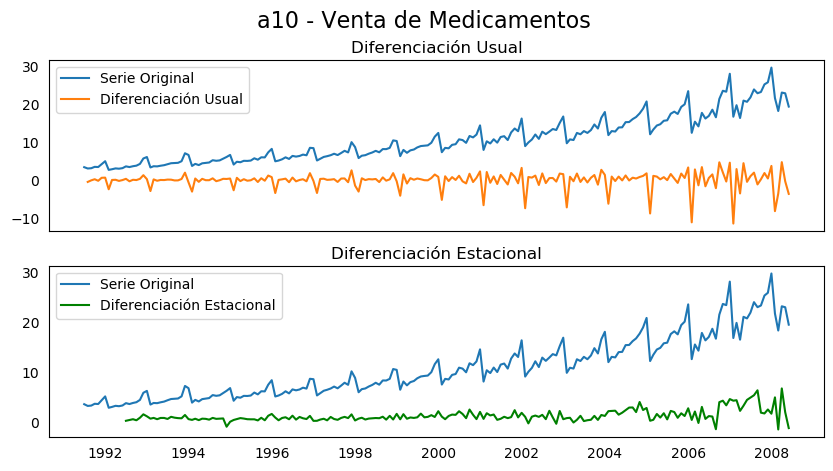

In [81]:
### Importamos datos
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                   parse_dates=['date'],
                   index_col='date')

### Gráfica
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

### Diferenciación usual
axes[0].plot(data[:], label='Serie Original')
axes[0].plot(data[:].diff(1), label='Diferenciación Usual')
axes[0].set_title('Diferenciación Usual')
axes[0].legend(loc='upper left', fontsize=10)


### Diferenciación estacional
axes[1].plot(data[:], label='Serie Original')
axes[1].plot(data[:].diff(12), label='Diferenciación Estacional', color='green')
axes[1].set_title('Diferenciación Estacional')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Venta de Medicamentos', fontsize=16)
plt.show()

Podemos claramente observar que las crestas estacionales están intactas después de aplicar diferenciación usual (lag1), pero se rectifican después de la diferenciación estacional.

Construyamos ahora un modelo SARIMA usando la librería *pmdarima* y la función *auto_arima()*. Para hacerlo necesitaremos poner el argumento *seasonal=True*, fijaremos la frecuencia en $m=12$ para serie mensual y forzaremos $D=1$.

In [82]:
import pmdarima as pm

### Ajuste estacional por pasos: auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=534.818, BIC=551.105, Fit time=1.974 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=624.061, BIC=630.576, Fit time=0.032 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=596.068, BIC=609.098, Fit time=0.558 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=611.475, BIC=624.505, Fit time=0.652 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=757.274, BIC=760.532, Fit time=0.044 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=559.407, BIC=572.437, Fit time=0.450 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=554.828, BIC=574.373, Fit time=3.501 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 2, 12); AIC=536.817, BIC=556.362, Fit time=6.564 s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(3, 0, 1)x(1, 1, 2, 12)   Log Likelihood                -250.092
Date:                            Sun, 09 Feb 2020   AIC                            518.185
Time:                                    09:16:19   BIC                            547.502
Sample:                                         0   HQIC                           530.059
                                            - 204                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0249      0.033      0.747      0.455      -0.041       0.090
ar.L1         -0.1244      0.150     -0.831      0.406      -0.418       0.169
ar.L2          0.4836      0.061      7.882      0.000       0.363       0.604
ar.L3          0.5240      0.083      6.328      0.000       0.362       0.686
ma.L1          0.1946      0.164      1.184      0.236      -0.127       0.517
ar.S.L12       0.8420      0.124      6.815      0.000       0.600       1.084
ma.S.L12      -1.6382      0.160    -10.265      0.000      -1.951      -1.325
ma.S.L24       0.8296      0.123      6.747      0.000       0.589       1.071
sigma2         0.6963      0.083      8.342      0.000       0.533       0.860
===================================================================================
Ljung-Box (Q):                       61.08   Jarque-Bera (JB):               104.14
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):              12.73   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Nuestro AIC es bajo y los p-values son significativos, entonces pronostiquemos los siguientes 24 meses:

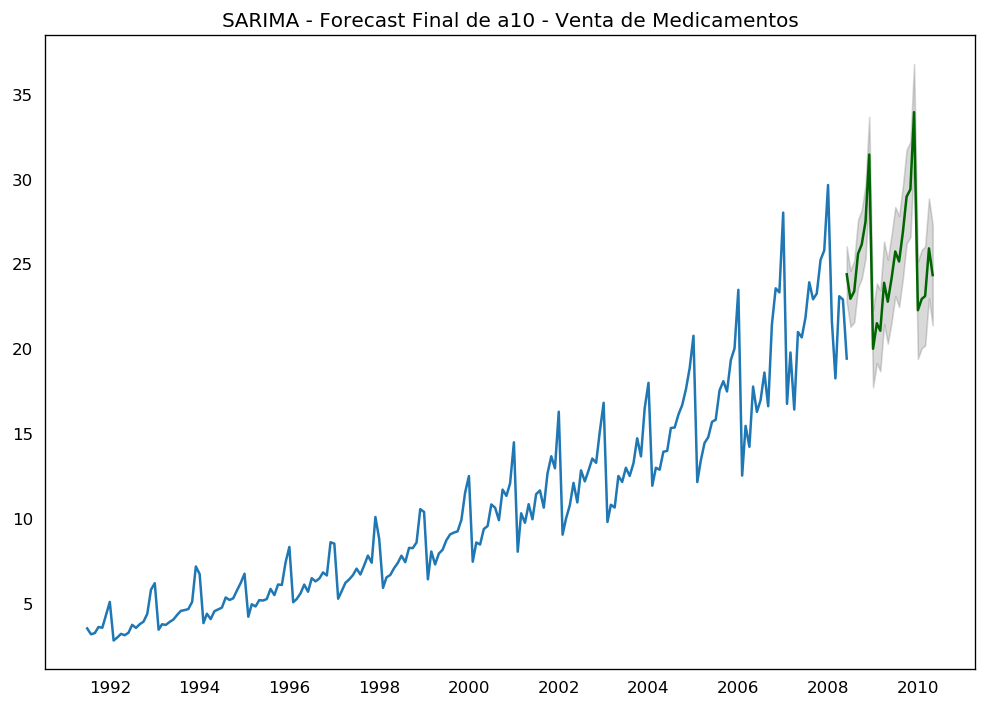

In [83]:
### Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

### Creamos series para graficar
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

### Gráfica
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Forecast Final de a10 - Venta de Medicamentos")
plt.show()

Ahí tenemos un buen forecast que logra capturar el patron de demanda estacional.

## 15. Construyendo un Modelo SARIMAX con una Variable Exógena

Ahora añadiremos un predictor externo (variable exógena) al modelo. Este modelo se llama **SARIMAX**.

El único requerimiento para usar este tipo de variables es que necesitamos conocer el valore de la variable durante el periodo de forecast también.

Para demostrar esto, usaré el ídice estacional de la descomposición estacional clásica en los últimos 36 meses de datos.

¿Por qué usar estos datos? ¿No el modelo SARIMA ya había pronosticado la esatcionalidad?

Esto es correcto, pero también queremos ver cómo se desempeña el modelo si forzamos el patrón de estacionalidad reciente en el conjunto de entrenamiento y en el forecast.

Además podemos usar esto para armar un buen template y meter cualquier variable al código. El índice estacional es una buena variable exógena porque se repite cada ciclo, 12 meses en este caso.

De modo que siempre sabremos qué valores tendrá el índice estacional para el forecast futuro.

In [84]:
### Importamos datos
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                   parse_dates=['date'],
                   index_col='date')

Calculemos ahora el índice estacional para que podamos forzarlo como una variable exógena predictora para el SARIMAX:

In [85]:
### Calculamos Índice Estacional
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

### Componente estacional multiplicativo
result_mul = seasonal_decompose(data['value'][-36:],   ### 3 años
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

### Merge con los datos
data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = data.index  ### reasignamos el índice.

La variable exógena está lista, ahora construiremos nuestro modelo SARIMAX:

In [86]:
import pmdarima as pm

### Modelo SARIMAX 
sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=536.818, BIC=556.362, Fit time=3.148 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=626.061, BIC=635.834, Fit time=0.056 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=598.068, BIC=614.356, Fit time=1.021 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=613.475, BIC=629.762, Fit time=0.880 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=759.274, BIC=765.789, Fit time=0.383 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=561.407, BIC=577.695, Fit time=1.188 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=556.837, BIC=579.639, Fit time=4.082 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 2, 12); AIC=538.817, BIC=561.620, Fit time=8.033 s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(3, 0, 1)x(1, 1, 2, 12)   Log Likelihood                -250.092
Date:                            Sun, 09 Feb 2020   AIC                            520.184
Time:                                    10:03:46   BIC                            552.759
Sample:                                07-01-1991   HQIC                           533.377
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0250      0.033      0.748      0.454      -0.040       0.090
seasonal_index  8.929e-06   7.65e+04   1.17e-10      1.000    -1.5e+05     1.5e+05
ar.L1             -0.1249      0.150     -0.835      0.404      -0.418       0.168
ar.L2              0.4836      0.062      7.831      0.000       0.363       0.605
ar.L3              0.5247      0.083      6.329      0.000       0.362       0.687
ma.L1              0.1942      0.165      1.177      0.239      -0.129       0.518
ar.S.L12           0.8417      0.123      6.862      0.000       0.601       1.082
ma.S.L12          -1.6412      0.161    -10.193      0.000      -1.957      -1.326
ma.S.L24           0.8335      0.125      6.646      0.000       0.588       1.079
sigma2             0.6943      0.084      8.223      0.000       0.529       0.860
===================================================================================
Ljung-Box (Q):                       61.10   Jarque-Bera (JB):               103.73
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):              12.74   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ya tenemos un modelo con un término exógeno, pero el coeficiente de $x_{1}$ es muy pequeño, así que la contribución de dicha variable es despreciable. Aun así la pronosticaremos.

Hemos forzado con éxito el último efecto estacional en los últimos 3 años dentro del modelo en vez de hacerlo para toda su hisotria.

Pronostiquemos entonces los siguientes 24 meses. Para esto, necesitamos el valor del índice estacional para los siguientes 24 meses.

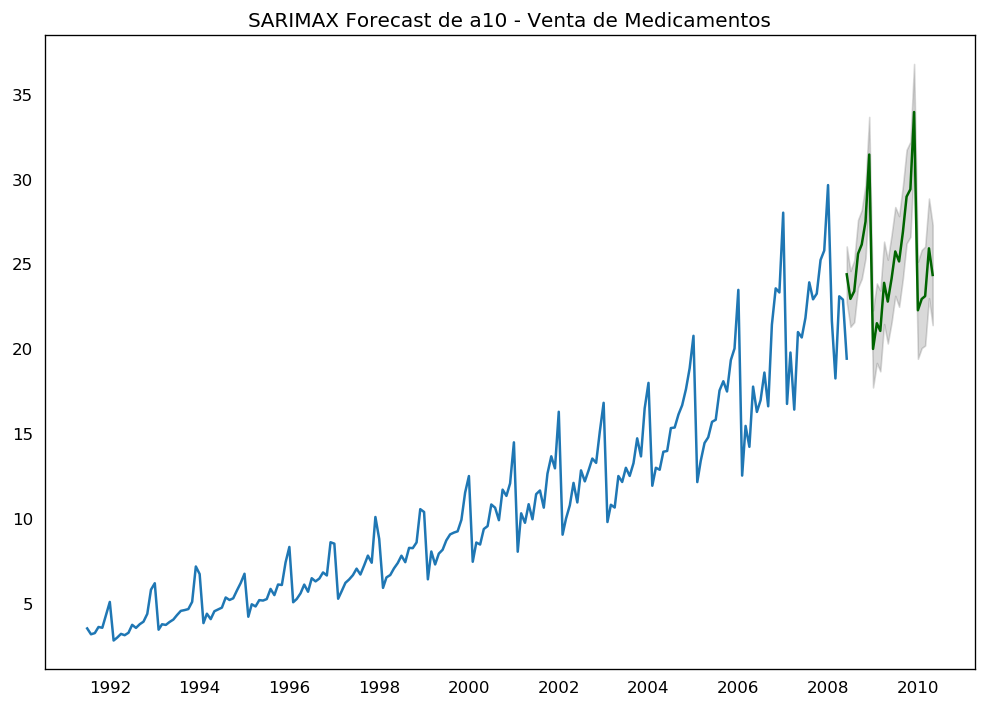

In [87]:
### Forecast
n_periods = 24
fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index.value, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

### Creamos serie para graficar
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

### Gráfica
plt.plot(data['value'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast de a10 - Venta de Medicamentos")
plt.show()

## Conclusión

Listo, aprendimos los conceptos necesarios desde lo fundamental de Series de Tiempo, así como los básicos de forecasting. 


Cubrimos los modelos AR, MA, ARIMA, SARIMA y finalmente SARIMAX.